In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import metabolinks as mtl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats
import multianalysis as ma
import metabolinks.transformations as transf
import netlsd as nl
import itertools

# Formula Networks

This notebook will cover the explorative studies into making networks from a list of formulas. Each formula will represent a node. Nodes will be connected if their respective formulas can be interconverted by a simple chemical reaction (enzymatic or non-enzymatic) that are represented by shifts in the elemental composition of the formula. For example, a methylation would correspond to adding a CH2 group to the formula.

### Groups to Consider

One of the most critical questions of this endeavour is which groups to consider to represent the different possible simple chemical reactions. Ideally, they should cover most common enzymatic and non-enzymatic reactions while also being a relatively small amount of reactions. The first iteration of this attempt consider 14 different groups. Of those, 8 remain among the 16 now considered.

- CH2 (methylation) EC 2.1.1
- OH (hydroxylation) when? Does SH too? OH only when other things leave I think
- O (oxygenation) EC1?
- H2 (Hydrogenation) EC1?
- O(-NH) (Aminase) instead of NH2? (NH3(-O) - H2) EC3.5 EC6.3
- PO3H (phosphorylation) EC2.7 
- NH3(-O) (transaminases)  EC2.6.1
- SO3 (sulphation) EC2.8.2
- CO (things like formylation) EC2.1.2
- CO2 (carboxylation, decarboxylation) EC2.1.3 EC4 (CO+O) 
- CHOH (Hydroxymethylation) EC2.1.2 (CH2 + O)
- NCH (formidoyltransferase) EC2.1.2.4/5
- CONH (carbamoyltransferase) EC2.1.3 (NCH + O)
- C2H2O (acetylation) EC2.3 (CO+CH2)
- S EC2.8.1 somewhat rare but we need more S reactions
- H2O (cyclizations like in 3.5.2?) (H2 + O)


##### Extra group transfers found that could be used maybe? 

- CN2H2 Amidinotransferases  EC.2.1.4 (only 2 enzymes)
- Transketolases and transaldolases EC2.2
- Most acyltransferases EC2.3
- COCH2COO (malonyl) - too big? EC2.3
- EC2.4 GLycosyltransferases - too big
- EC2.5 alkyl and aryl groups bigger than methyl - dimethylalyl best candidate to include - 
- EC 2.6.3.1 JUst one enzyme NH
- Some of the later EC2.7 have groups connected to the phosphate
- S2O2 not worth
- Nitrile Hydrolase (H202(-N))

### Extensions made

Since the overall idea mentioned was generating massively underconnected networks despite the 14 groups used (originally) to establish the network, an extension to the concept was applied to generate more connected networks that could be more reliably analysed.

The extension took into account the possibility of "missing links". That is, a metabolite in chain of a certain group could be missing so we try to add multiple of said groups to see if there are further elements in the chain. This was done until a maximum of 5 groups away. Of course, the more multiples of a group needed to connect to another formula, the weaker said connection is. This was represented by the attribute weight where a value of 1 was added to the weight for each extra multiple added.

For example, imagine the node C10H20O6. Testing a connection with the CH2 group, we try to find the node C11H22O6. If it doesn't exist, we can see if it's a missing link in the chain and search for the node further on in the chain with 2 more CH2 groups that C10H20O6, that is, the node C12H2406, then C13H26O6, until a maximum of 5 more CH2 groups in relation to the original node. Imagine C12H24O6 doesn't exist, but the node C13H26O6 exists. So the node is connected to C10H20O6 but with the weight/distance of 3 instead of the normal 1, since the distance between the nodes is equal to 3 CH2 groups.

### Reading the files

So before anything else, we will have to read the files for the datasets we are going to use. The main dataset that we will use will be the yeast dataset that we will read somewhat similarly to yeast_new notebook although slightly different since we don't need so many modifications. 

We will also have the grapevine dataset on standby if we want to experiment with it.

#### Reading Yeast dataset

Most of this was taken from the yeast_new notebook.

File and formulas given by the MetaboScape software.

In [2]:
def reading_MetScape_file(filename,
                          col_renamer=None,
                          add_labels=None,
                          remove_ref_feat=None,
                          prefix_to_drop=None):
    
    """Read in a MetaboScape bucket table from a CSV file."""
    
    data = pd.read_csv(filename).set_index('Bucket label')
    data = data.sort_values(by = 'm/z')
    
    # optionally rename sample_names
    if col_renamer is not None:
        data = data.rename(columns=renamer)
    
    # optionally remove columns with a given prefix. Eg. 'ENO'
    if prefix_to_drop is not None:
        cols2drop = [c for c in data.columns if c.startswith(prefix_to_drop)]
        data = data.drop(columns=cols2drop)
    
    # optionally remove a reference feature (if already normalized)
    if remove_ref_feat is not None:
        #print(f'Feature {remove_ref_feat}\n{data.loc[remove_ref_feat, :]}\n----------')
        data = data.drop(index=[remove_ref_feat])
    
    # split in peak metadata and intensities
    # peak_cols = ['m/z', 'Name', 'Formula']
    # intensity_cols = [c for c in list(data.columns) if c not in peak_cols]
    # peaks = data[peak_cols]
    # intensities = data[intensity_cols]

    # replace zeros for NaN's
    #intensities = intensities.replace(0, np.nan).dropna(how='all')
    
    # force peaks to have the same features as the (trimmed) intensities
    #peaks = peaks.reindex(intensities.index)

    # optionally, add labels to intensities
    if add_labels is not None:
        data = mtl.add_labels(data, labels=add_labels)
    
    return data

In [3]:
def renamer(colname):
    # Useful to optionally remove all those 00000 from sample names
    return ''.join(colname.split('00000'))

leu_enk_name = '555.2692975341 Da'

labels = 'Metadata BY4741 dGRE3 dENO1 dGLO1 dGLO2'.split() # if ENO is removed, change this
labels = 'BY4741 dGRE3 dENO1 dGLO1 dGLO2'.split() # if ENO is removed, change this

In [4]:
# Read in the two files and keep results in dicts 
prefix_to_drop = None # change to 'ENO' to remove ENO strain

yeast_data = reading_MetScape_file('5yeasts_notnorm_2.csv', 
                                       remove_ref_feat=None,
                                       add_labels=None,
                                       col_renamer=renamer,
                                       prefix_to_drop=None)
yeast_data

,m/z,Name,Formula,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
Bucket label,,,,,,,,,,,,,,,,,,
200.1775759522 Da,201.18485,Butyl octanoate,C12H24O2,0.00,0.00,0.000,5.524132e+05,648388.25,6.080372e+05,6.375496e+05,610135.875,656653.625,6.310158e+05,6.798519e+05,5.984907e+05,9.431856e+05,8.160908e+05,8.172168e+05
200.2661522455 Da,201.27343,NaN,NaN,0.00,0.00,575903.125,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
200.2930225885 Da,201.30030,NaN,NaN,1238710.75,1275006.75,1283941.750,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,8.679426e+05,7.015142e+05,7.361217e+05
201.1727696159 Da,202.18005,NaN,C11H23NO2,3945019.75,3852594.00,3821208.250,4.204017e+06,4131124.25,4.059027e+06,4.352161e+06,4440771.000,4499343.500,4.345543e+06,4.091804e+06,4.545699e+06,4.248517e+06,4.207834e+06,4.208490e+06
201.1729328725 Da,202.18021,NaN,C11H23NO2,3404298.50,3366785.00,3348790.750,3.672346e+06,3737722.00,3.793184e+06,3.923927e+06,3804580.500,3801558.250,3.835366e+06,3.708862e+06,3.889770e+06,3.635306e+06,3.618243e+06,3.543283e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995.1450511879 Da,2996.15233,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,5.629427e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2995.8961895300 Da,2996.90347,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,5.415538e+05,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2996.7812722438 Da,2997.78855,NaN,NaN,0.00,0.00,0.000,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000,0.000,5.776696e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


feature_filter function is used to join different features that share the same formula by adding all of the intensity in each sample for each of those features. The exact m/z that remains corresponds to the feature that contributes the most to the full intensity of the different features that share the formula.

In [5]:
def feature_filter(Spectra):
    """Join all features that share the same formula by simple addition.
       
       Spectra: AlignedSpectra object (from metabolinks).
       
       Returns: Aligned Spectra object (from metabolinks) with filtered dataset.
    """
    df = Spectra
    #Variables to store results
    rp = pd.DataFrame(columns = df.columns)
    rep = []
    #Series with number of times each formula appears in the dataset
    form_count = df['Formula'].value_counts()
    a = 0
    
    for i in df['Formula']:
        if pd.isnull(i) == True: #If no formula is assigned to the feature, the feature stays in the new dataset
            rp = rp.append(df.iloc[a,:])

        else:
            if form_count[i] > 1: #If the formula appears more than one time in the dataset
                if i not in rep: #And If it didn't already appear before
                    #Bucket label, name and formula info are the ones from the greater intensity m/z peak (of peaks with the
                    #same formula)
                    peaks = df.loc[df['Formula'] == i,:].iloc[:,3:].sum(axis = 1)
                    peaks_idx = peaks.idxmax()
                    info = df.loc[peaks_idx].iloc[:3]
                    newrow = df.loc[df['Formula'] == i,:].iloc[:,3:].sum(axis = 0) #Addition of all m/z peaks intensity
                    newrow_c = pd.concat([info, newrow], axis = 0)
                    #m/z peak stays is from the greater intensity m/z peak (of peaks with the same formula)
                    newrow_c = newrow_c.rename(df.loc[peaks_idx].name)
                    #Append peak with intensity added from all peaks sharing the same formula
                    rp = rp.append(newrow_c)

                    rep.append(i) #Append repeating formulas so this process isn't repeated again for the other m/z peaks

            else:
                rp = rp.append(df.iloc[a,:]) #Append peaks with formulas that aren't repeated in the dataset
        a = a + 1
    #return dataframe in AlignedSpectra format.
    return rp

In [6]:
yeast_df = yeast_data.dropna(subset = ['Formula'])
yeast_df = feature_filter(yeast_df)
yeast_df = yeast_df[yeast_df.iloc[:,0] < 800]

In [7]:
#Only keep features that appear in at least two samples
yeast_df_temp = transf.keep_atleast(yeast_df.iloc[:,3:].replace({0:np.nan}), min_samples=2)
yeast_df = yeast_df.loc[yeast_df_temp.index]
yeast_df.loc[yeast_df_temp.index]

for i in yeast_df['Formula']:
    if 'Cl' in i:
        yeast_df = yeast_df.drop(yeast_df[yeast_df['Formula'] == i].index)

yeast_df

,m/z,Name,Formula,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
200.1775759522 Da,201.18485,Butyl octanoate,C12H24O2,0.000000e+00,0.000000e+00,0.000000e+00,5.524132e+05,6.483882e+05,6.080372e+05,6.375496e+05,610135.875,656653.625,6.310158e+05,6.798519e+05,5.984907e+05,9.431856e+05,8.160908e+05,8.172168e+05
201.1727696159 Da,202.18005,NaN,C11H23NO2,7.349318e+06,7.219379e+06,7.169999e+06,7.876362e+06,7.868846e+06,7.852211e+06,8.276088e+06,8245351.500,8300901.750,8.180909e+06,7.800666e+06,8.435469e+06,7.883823e+06,7.826076e+06,7.751774e+06
201.9791043208 Da,202.98638,NaN,C4H10O3S3,5.979574e+05,0.000000e+00,5.714457e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
203.1156661180 Da,204.12294,L-Acetylcarnitine,C9H17NO4,9.080770e+06,8.507996e+06,8.790471e+06,1.306664e+07,1.276478e+07,1.262020e+07,4.052399e+06,4071939.375,3710997.750,5.500948e+06,5.500034e+06,5.690336e+06,5.576097e+06,5.274222e+06,5.336592e+06
203.1268992141 Da,204.13418,Glycyl-Lysine,C8H17N3O3,1.552573e+06,1.624512e+06,1.601379e+06,2.134372e+06,2.044589e+06,1.159726e+06,2.132446e+06,2235339.375,1278033.000,6.275618e+05,5.937806e+05,6.216861e+05,2.329378e+06,2.365200e+06,2.431183e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796.0463497577 Da,797.05363,NaN,C20H44N8O3S11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,742966.875,0.000000e+00,0.000000e+00,6.060865e+05,0.000000e+00,0.000000e+00,0.000000e+00
796.1262273836 Da,797.13350,NaN,C38H40N2O5S6,6.317694e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.160822e+05
796.3603059332 Da,797.36758,NaN,C27H68N6O10S5,0.000000e+00,0.000000e+00,5.712139e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000000e+00,5.823774e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
796.6386463984 Da,797.64592,NaN,C35H96N4O8S3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,6.919722e+05,0.000000e+00,0.000000e+00,6.831370e+05,0.000000e+00,0.000000e+00


#### Reading a sample from Grapevine dataset (in case of necessity)

File and formulas from the Formularity software (free formula assigning software)

In [8]:
#CAN file with parameters: N+S+P Formula score, 1 ppm, 800 limit database
#Gv_CAN1 = pd.read_csv('Formularity_data/CAN_NSP_1_800.csv')
#Gv_CAN1[Gv_CAN1['El_comp'].notnull()]

### Functions to change how each formula is represented

On the dataset, each formula is represented as a string with the following structure: 'CxHxNxOxPxSx' where x is the number of each element. If x=1, it is absent; if x=0, the element itself won't appear in the formula.

The objective of the following function is to transform all formulas into a dataframe where each element will be represented by a column with the names 'C','H','O','N','S','P' while each "string" formatted formula will be the index of each row.

The main function is called deformulator since we are de-construting the formulas format.

In [9]:
def deformulator(df):
    """Transforms a set of formulas in string format into a DataFrame with columns corresponding to each element.
       Element order: Order of the elements in the formulas.
    """
    
    filtered_formulas = df['Formula'].dropna() #Dropping empty cells (without formulas)
    
    formula = {}
    for i in filtered_formulas:
        if 'C(13)' in i:
            #Ignores C(13) formulas - the C12 formulas already exist
            continue
        else:
            #Transform the string representing the formula into a dictionary and store all results in a dictionary
            formula[i] = formula_process(i)
            #formulas.loc[filtered_formulas[filtered_formulas == i].index[0]] = formula_process(i).iloc[0]
            
    #Transforming the dictionary of dictionaries into the pretended dataframe
    formula_df = pd.DataFrame.from_dict(formula).T
    formula_df = formula_df.replace({np.nan:0}) #Replace nan values when an element doesn't appear in a formula for 0
    
    return formula_df

In [10]:
def formula_process(formula):
    """Transforms a formula in string format into a dictionary."""
    
    #results = pd.DataFrame(np.zeros((1,8)), columns = ['C','H','O','N','S','P','Cl','F'])
    #Empty dictionary to store the results
    results = {}
    count = ''
    letter = None
    
    #Run through the string
    for i in range(len(formula)):
        if formula[i].isupper(): #If i is an uppercase letter then it is an element
            if letter: #Just to account for the first letter in the formula where letter is None
                results[letter] = int(count or 1) #Reached another letter, store previous results and reset count
                count = ''
                
            if i+1 < len(formula): #In case it's a two letter element such as Cl
                if formula[i+1].islower(): #The second letter is always lower case
                    letter = formula[i] + formula[i+1] #Store new 2 letter element
                    continue
                    
            letter = formula[i] #Store new 1 letter element
            
        elif formula[i].isdigit():
            count = count + formula[i] #If number, add number to count
    
    #Store results of the last letter
    results[letter] = int(count or 1)
                    
    return results

## Example of Building a Network for a single sample

Sample chosen: Replicate nº 2 of the yeast strain BY

First, select the formulas that appear in that sample and use deformulator to get the needed dataframe.

In [11]:
BY2 = yeast_df[yeast_df.iloc[:,4] != 0] #Taking only formulas/rows that were present in the sample
formula_df = deformulator(BY2)
formula_df = formula_df[['C','H','O','N','S','P']] #Make the order of the elements better for us
formula_df.index = BY2['Formula'] #The string format formulas become the index
#BY2[BY2['Formula'] is in ['C18H34O3','C18H34O4', 'C19H36O3','C17H32O2']]
formula_df

,C,H,O,N,S,P
Formula,,,,,,
C11H23NO2,11.0,23.0,2.0,1.0,0.0,0.0
C9H17NO4,9.0,17.0,4.0,1.0,0.0,0.0
C8H17N3O3,8.0,17.0,3.0,3.0,0.0,0.0
C7H12N2O5,7.0,12.0,5.0,2.0,0.0,0.0
C6H10N2S3,6.0,10.0,0.0,2.0,3.0,0.0
...,...,...,...,...,...,...
C37H85NO9P2S,37.0,85.0,9.0,1.0,1.0,2.0
C29H14N22O3S2,29.0,14.0,3.0,22.0,2.0,0.0
C22H23N16O13PS,22.0,23.0,13.0,16.0,1.0,1.0


Now we have a dataframe where each column represents a columns which will be filled in each with the number of that element in the formula that represents the row.

We have to build a graph and establish connections between the formulas.

### Functions for Graph building

Here we put the  functions we will need to build the different graphs, to add edges and edge attributes.

- edge_finder: searches for a specific edge between the selected node and all the other nodes for one of the simple chemical reactions.
- edge_assembler: performs all possible connections (with all the groups chosen) in the network by applying in succession edge_finder to each pair of node and chemical reaction. It also returns a dictionary with a measure of the number of times a chemical reaction was used to connect different nodes with connections "far away" contributing with the inverse of their weight.
- inverse_weight_attributer: gives and edge attribute to the graph that is the inverse of the weight of each edge to use with the weighted degree to give less important to connections "far away".

In [12]:
def edge_finder(G, df, node, c=0, h=0, o=0, n=0, s=0, p=0, depth=5, group=''):
    """Creates edges in a network between different formulas with specific elemental differences.
    
       G: networkX graph object; graph where edges will be added.
       df: Pandas DataFrame; dataframe with information about the formulas representing each node.
       node: Pandas Series/row of a DataFrame; specific node which will be connected with other similar nodes (row from the
    above DataFrame).
       c,h,o,n,s,p: int's; integers representing the difference each element (C,H,O,N,S,P respectively) should have between
    2 formulas to connect them with an edge.
       depth: int; number of possible 'missing links' between the 2 formulas accepted (weight of the node will be equal to the
    depth).
    
       returns: the weight of the edge established in the G network (0 if an edge isn't established)."""
    
    #See if there is a formula with the specified difference in relation to the chosen node
    choose = df[df['C'] == node['C'] + c]
    choose = choose[choose['H'] == node['H'] + h]
    choose = choose[choose['O'] == node['O'] + o]
    choose = choose[choose['N'] == node['N'] + n]
    choose = choose[choose['S'] == node['S'] + s]
    choose = choose[choose['P'] == node['P'] + p]
    
    if len(choose) > 0: #If a node was found
        G.add_edge(node.name,choose.index[0], weight = 1, group=group)
        return 1 #The weight
    
    else:
        for j in range(2, depth+1):
            #See if there is a formula with j times the specified difference in relation to the chosen node
            #This is performed from 2 until the maximum depth given
            choose = df[df['C'] == node['C'] + j*c]
            choose = choose[choose['H'] == node['H'] + j*h]
            choose = choose[choose['O'] == node['O'] + j*o]
            choose = choose[choose['N'] == node['N'] + j*n]
            choose = choose[choose['S'] == node['S'] + j*s]
            choose = choose[choose['P'] == node['P'] + j*p]
            
            #End the function if a node is found
            if len(choose) > 0:
                G.add_edge(node.name,choose.index[0], weight = j, group=group)
                return j #The weight
    
    return 0 #No other node was found to connect the given node to

In [13]:
def edge_assembler(formula_df, G, depth=5):
    """Add all wanted possible edges to the formula network created and return a dictionary of the influence of each group
    in establishing the edges.
       
       G: networkX graph object; graph where edges will be added.
       formula_df: Pandas DataFrame; dataframe with information about the formulas representing each node.
       
       returns: dictionary with the importance of each group in building the network.
    """
    
    #I can use this to automatically calculate the difference with deformulator but it is slower
    #groups = ['H2','CH2','CO2','O','CHOH','NCH','O(-NH)','OH','S','CONH','PO3H','NH3(-O)','SO3','CO', 'C2H2O', 'H2O']
    #group_influence = dict.fromkeys(groups,0)
    
    #For each possible node in the dataframe, try to find all connections to it
    for i in formula_df.index:
        #print(i)
        node = formula_df.loc[i]
        
        #H2
        edge_finder(G, formula_df, node, h=2, depth=depth, group='H2')
        
        #CH2
        edge_finder(G, formula_df, node, c=1, h=2, depth=depth, group='CH2')

        #CO2
        edge_finder(G, formula_df, node, c=1, o=2, depth=depth, group='CO2')

        #O
        edge_finder(G, formula_df, node, o=1, depth=depth, group='O')

        #CHOH
        edge_finder(G, formula_df, node, c=1, h=2, o=1, depth=depth, group='CHOH')

        #NCH
        edge_finder(G, formula_df, node, c=1, h=1, n=1, depth=depth, group='NCH')

        #O(-NH)
        edge_finder(G, formula_df, node, h=-1, o=1, n=-1, depth=depth, group='O(-NH)')

        #OH
        edge_finder(G, formula_df, node, h=1, o=1, depth=depth, group='OH')

        #S
        edge_finder(G, formula_df, node, s=1, depth=depth, group='S')

        #CONH
        edge_finder(G, formula_df, node, c=1, h=1, o=1, n=1, depth=depth, group='CONH')
    
        #PO3(H)
        edge_finder(G, formula_df, node, h=1, o=3, p=1, depth=depth, group='PO3H')

        #NH3-O
        edge_finder(G, formula_df, node, h=3, o=-1, n=1, depth=depth, group='NH3(-O)')

        #SO3
        edge_finder(G, formula_df, node, h=0, o=3, s=1, depth=depth, group='SO3')

        #CO
        edge_finder(G, formula_df, node, c=1, o=1, depth=depth, group='CO')
            
        #C2H2O
        edge_finder(G, formula_df, node, c=2, h=2, o=1, depth=depth, group='C2H2O')
        
        #H2O
        edge_finder(G, formula_df, node, h=2, o=1, depth=depth, group='H2O')   

In [14]:
def inverse_weight_attributer (graph):
    """Adds an inverse weight attribute to the edges to do a specific degree count."""
    
    wei = {}
    for i in graph.edges.data('weight'):
        wei[(i[0], i[1])] = 1/i[2]
    nx.set_edge_attributes(graph, wei, 'weight_inv')

### Building a graph

First, we set up the graph Gr using the module NetworkX that will be mainly used from now on and add all the formulas as different nodes in the graph.

Then we use the edge_assembler function to establish all the edges in the network and return a dictionary of the influence of each chemical group (representing types of chemical reactions) in establishing the edges in said network (slow) and the inverse_weight_attributer to add another edge attribute which will be useful later. 

In [15]:
Gr = nx.Graph()
#Gr.add_nodes_from(['C18H34O3','C18H34O4', 'C19H36O3','C17H32O2'])
Gr.add_nodes_from(formula_df.index) #Each formula is a node
nx.set_node_attributes(Gr,BY2.set_index(BY2['Formula'])['BY0_1'].to_dict(), name='Intensity') #Store intensity of each node

In [16]:
len(Gr.nodes())
#Gr.nodes()

594

In [17]:
BY2_groups = edge_assembler(formula_df,Gr) #Adding the edges
inverse_weight_attributer(Gr) #Adding the inverse weight attrbiute

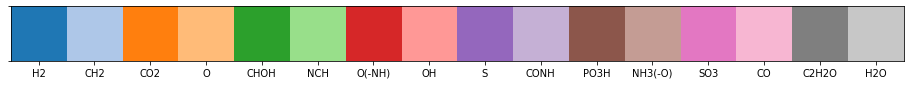

In [18]:
colours = sns.color_palette('tab20', 16)

#unique_group = set(nx.get_edge_attributes(Gr,'group').values())
unique_group = ['H2','CH2','CO2','O','CHOH','NCH','O(-NH)','OH','S','CONH','PO3H','NH3(-O)','SO3','CO', 'C2H2O', 'H2O']
group_colors = {lbl: c for lbl, c in zip(unique_group, colours)}

sns.palplot(group_colors.values())
new_ticks = plt.xticks(range(len(unique_group)), unique_group)

edge_colors =  [group_colors[lbl] for lbl in nx.get_edge_attributes(Gr,'group').values()]

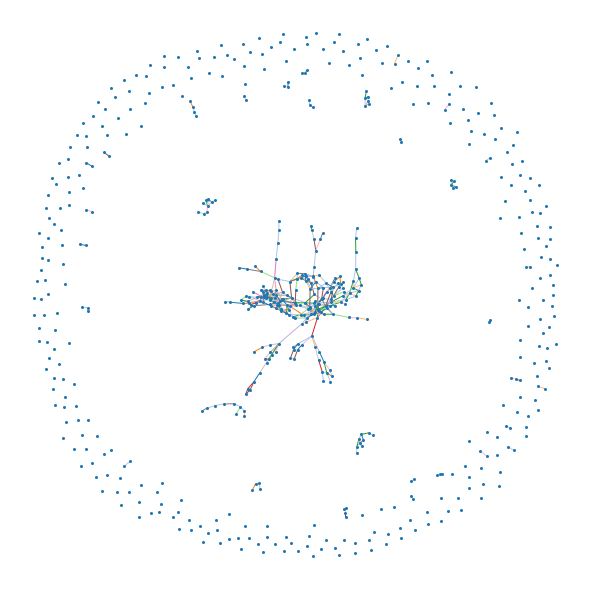

In [19]:
#Drawing the graph
plt.figure(figsize=(8,8))
nx.draw(Gr, node_size=4, width = 1, edge_color=edge_colors)#, with_labels=True)
plt.show()

In [20]:
#Main components of the network built
[len(c) for c in sorted(nx.connected_components(Gr), key=len, reverse=True)][:20]

[138, 47, 9, 9, 9, 8, 6, 5, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2]

In [21]:
#Group Influence in building the network
BY2_groups = dict.fromkeys(unique_group, 0)
for i in Gr.edges():
    BY2_groups[Gr.edges()[i]['group']] = BY2_groups[Gr.edges()[i]['group']] + Gr.edges()[i]['weight_inv']
BY2_groups

{'H2': 38.53333333333333,
 'CH2': 83.48333333333333,
 'CO2': 17.0,
 'O': 45.76666666666667,
 'CHOH': 35.83333333333333,
 'NCH': 12.2,
 'O(-NH)': 9.0,
 'OH': 7.5,
 'S': 3.0,
 'CONH': 6.75,
 'PO3H': 16.0,
 'NH3(-O)': 9.333333333333332,
 'SO3': 3.0,
 'CO': 25.666666666666668,
 'C2H2O': 19.333333333333332,
 'H2O': 31.033333333333335}

#### Some conclusions:

Seems like the 'S' and the 'CONH' group aren't being very useful to establish connections. 'SO3' also doesn't seem very useful, which is surprising since adding a SO3 group should be a somewhat "common" reaction. These conclusions can be more easily taken by analysing the full possible yeast dataset - end of the notebook.

In [22]:
a = 0
for i in BY2_groups.values():
    a = a + i
a

363.43333333333334

3 measures of centrality were used to analyze the networks: degree, centrality_closeness, betweenness_centrality. The last two use the weights of the different edges and degree uses the inverse of the weight as given by the function inverse_weight_attributer, that is, if an edge has a weight/distance of x, it's contribution to the degree of each node will be 1/x.

In [23]:
nx.degree(Gr)
G_degree = dict(Gr.degree(weight='weight_inv'))
G_degree_all = sorted(G_degree.items(), key=lambda kv: kv[1], reverse = True)
G_degree_all[:20]

[('C18H34O3', 10.5),
 ('C18H34O4', 8.833333333333332),
 ('C16H30O2', 8.5),
 ('C16H30O3', 8.5),
 ('C17H34O2', 7.5),
 ('C23H45NO4', 7.5),
 ('C16H32O2', 7.0),
 ('C22H43NO3', 7.0),
 ('C18H34O2', 6.5),
 ('C19H36O3', 6.5),
 ('C22H41NO2', 6.5),
 ('C22H43NO4', 6.5),
 ('C18H37NO3', 6.333333333333334),
 ('C22H43NO2', 6.333333333333333),
 ('C18H32O3', 6.033333333333333),
 ('C17H32O2', 6.0),
 ('C11H19N3O7S', 6.0),
 ('C19H36O4', 6.0),
 ('C22H45NO3', 6.0),
 ('C18H36O2', 5.5)]

In [24]:
G_betw = nx.betweenness_centrality(Gr, weight = 'weight')
G_betw_all = sorted(G_betw.items(), key=lambda kv: kv[1], reverse = True)
G_betw_all[:20]

[('C18H37NO3', 0.012107823255125704),
 ('C21H42O4', 0.011864742250211637),
 ('C22H43NO4', 0.011070874873664647),
 ('C22H46O6', 0.010291235807677625),
 ('C21H44O5', 0.010210539634692132),
 ('C18H34O4', 0.00961548091046005),
 ('C20H41NO3', 0.007352217985262271),
 ('C23H48O6', 0.0068549005522024),
 ('C23H45NO4', 0.006612627777354276),
 ('C18H38NO6P', 0.006346526289769833),
 ('C18H34O3', 0.0054996109794491896),
 ('C16H30O2', 0.005399672252166119),
 ('C14H28O2', 0.005343668149984792),
 ('C18H32O3', 0.005332589236089689),
 ('C16H32O2', 0.005173821200908796),
 ('C22H44NO7P', 0.0042296352949852106),
 ('C23H47NO4', 0.004208818046903218),
 ('C16H28O', 0.0041293699313405445),
 ('C16H30O3', 0.003811177131184846),
 ('C25H52O7', 0.003775696619288522)]

In [25]:
G_closeness = nx.closeness_centrality(Gr, distance = 'weight')
G_closeness_all = sorted(G_closeness.items(), key=lambda kv: kv[1], reverse = True)
G_closeness_all[:20]

[('C18H37NO3', 0.04078727768988717),
 ('C18H34O4', 0.04068242607628849),
 ('C18H34O3', 0.0393179223445372),
 ('C19H36O4', 0.039171939959594615),
 ('C20H41NO3', 0.038978974738118774),
 ('C18H32O3', 0.03864582110787844),
 ('C17H34O2', 0.03850477796514896),
 ('C19H36O3', 0.03836476059073023),
 ('C22H43NO4', 0.03836476059073023),
 ('C18H37NO2', 0.038318314149337104),
 ('C18H36O2', 0.03804198015306784),
 ('C17H34O3', 0.03804198015306784),
 ('C19H38O4', 0.0379963115094267),
 ('C21H42O4', 0.0377696032068645),
 ('C18H34O2', 0.037634872160942266),
 ('C21H40O3', 0.03741244383847807),
 ('C19H38O2', 0.037280244390285565),
 ('C16H32O2', 0.037148975924122585),
 ('C18H35NO', 0.03697538257868276),
 ('C18H38NO6P', 0.03697538257868276)]

#### Heat Analysis

See the the diffusion of heat according to the package netlsd (nl) and plot the graph.

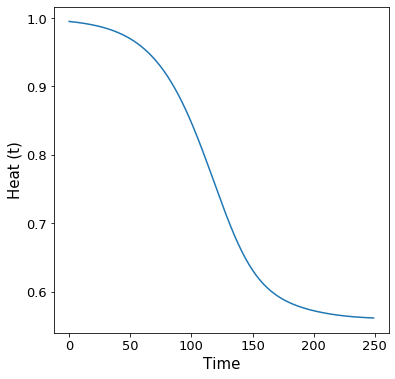

In [26]:
G_heat = nl.heat(Gr)

f, ax = plt.subplots(figsize=(6,6))
plt.plot(G_heat)    
        
plt.xlabel('Time', fontsize=15)
plt.ylabel('Heat (t)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

#### GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4 node graphlets) (see explanation after active cell 34-ish)

In [27]:
def calculating_orbits(GG):
    """Calculates the number of times each node of the netwrok is in each possible (non-redundant) orbit in graphlets (maximum
    4 nodes).
    
    Function is not very efficient, all nodes are passed, every graphlet is 'made' for each node present in it so it is made
    multiple times. Maybe should put more comments throughout the function
    
       GG: networkx graph;
    
       returns: dict; dictionary (keys are the nodes) of dictionaries (keys are the orbits and values are the number of times)
    """
    
    node_orbits = {} #To store results

    for i in GG.nodes():

        node_orbits[i] = {} #To store results
        orbits = node_orbits[i]

        ##size of comp
        #comp = len(nx.node_connected_component(GG, 'c'))

        #2 node graphlets - orbit 0
        orbits['0'] = GG.degree(i)

        #3 node graphlets - orbit 1,2 (and 3 redundant)
        node_neigh = list(GG.neighbors(i))

        #orbit 1 and 4 and 6 and 8 and 9
        n_orb = 0
        n_orb4 = 0
        n_orb6 = 0
        n_orb8 = 0
        n_orb9 = 0

        #orbit 1
        for j in node_neigh:
            neigh_neigh = list(GG.neighbors(j))
            neigh_neigh.remove(i)
            for common in nx.common_neighbors(GG, i, j):
                neigh_neigh.remove(common)
            n_orb = n_orb + len(neigh_neigh)


            #orbit 4 and 8
            for n3 in neigh_neigh:
                neigh_neigh_neigh = list(GG.neighbors(n3))
                #neigh_neigh_neigh.remove(j)
                #if i in neigh_neigh_neigh:
                    #neigh_neigh_neigh.remove(i)     
                for common in nx.common_neighbors(GG, j, n3):
                    if common in neigh_neigh_neigh:
                        neigh_neigh_neigh.remove(common)

                for common in nx.common_neighbors(GG, i, n3):
                    if common in neigh_neigh_neigh:
                        neigh_neigh_neigh.remove(common)
                        #orbit 8
                        if common != j:
                            #print(i,j,n3,common)
                            n_orb8 = n_orb8 + 1/2 #always goes in 2 directions so it will always pass like this

                n_orb4 = n_orb4 + len(neigh_neigh_neigh)
                #print(neigh_neigh_neigh)

            #orbit 6 and 9
            for u,v in itertools.combinations(neigh_neigh, 2):
                if not GG.has_edge(u,v):
                    n_orb6 = n_orb6 + 1
                else:
                    n_orb9 = n_orb9 + 1         

        orbits['1'] = n_orb

        #orbit 2 and 5
        n_orb = 0
        n_orb5 = 0
        for u,v in itertools.combinations(node_neigh, 2):
            if not GG.has_edge(u,v):
                n_orb = n_orb + 1

                #orbit 5
                neigh_u = list(GG.neighbors(u))
                neigh_u.remove(i)
                for common in nx.common_neighbors(GG, i, u):
                    neigh_u.remove(common)

                neigh_v = list(GG.neighbors(v))
                neigh_v.remove(i)
                for common in nx.common_neighbors(GG, i, v):
                    neigh_v.remove(common)

                for common in nx.common_neighbors(GG, v, u):
                    if common in neigh_u:
                        neigh_u.remove(common)
                    if common in neigh_v:
                        neigh_v.remove(common) 

                n_orb5 = n_orb5 + len(neigh_u)
                n_orb5 = n_orb5 + len(neigh_v)

        orbits['2'] = n_orb

        #4 node graphlets - orbit 4,5,6,7,8,9,10,11 (and 12,13,14 redundant)

        #orbit 4
        orbits['4'] = n_orb4

        #orbit 5
        orbits['5'] = n_orb5

        #orbit 6
        orbits['6'] = n_orb6

        #orbit 7 and 11
        n_orb = 0
        n_orb11 = 0
        for u,v,j in itertools.combinations(node_neigh, 3):
            n_edge = [GG.has_edge(a,b) for a,b in itertools.combinations((u,v,j), 2)]
            #print(sum(n_edge))
            if sum(n_edge) == 0:
                n_orb = n_orb + 1
            elif sum(n_edge) == 1:
                n_orb11 = n_orb11 + 1

        orbits['7'] = n_orb

        #orbit 8
        orbits['8'] = int(n_orb8)

        #orbit 9
        orbits['9'] = n_orb9

        #orbit10
        n_orb = 0
        for j in node_neigh:
            neigh_neigh = list(GG.neighbors(j))
            neigh_neigh.remove(i)
            for u,v in itertools.combinations(neigh_neigh, 2):
                if sum((GG.has_edge(i,u), GG.has_edge(i,v))) == 1:
                    if not GG.has_edge(u,v):
                        n_orb = n_orb + 1

        orbits['10'] = n_orb

        #orbit 11
        orbits['11'] = n_orb11
    
    return node_orbits

In [28]:
G_GCD = calculating_orbits(Gr)
G_GCD_df = pd.DataFrame.from_dict(G_GCD).T
CorrMat = stats.spearmanr(G_GCD_df,axis=0)[0]

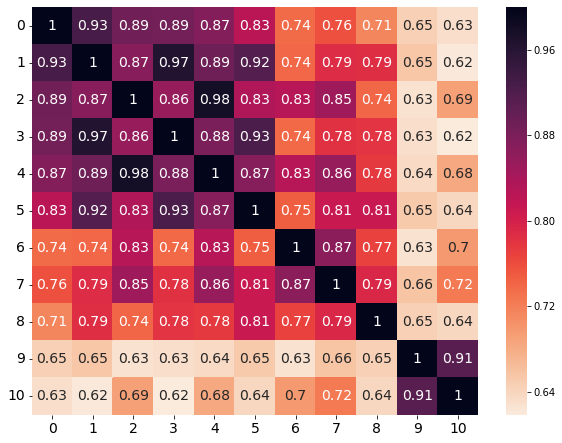

In [29]:
f, ax = plt.subplots(figsize=(10, 7.5))
hm = sns.heatmap(CorrMat, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 14})
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(11)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize= 14)
plt.show()

## Formula Network Analysis

### Building the formula network for each sample and gathering the main results from each network

edge_assembler function is slow

In [30]:
#Making all the graphs and storing
G = {}

#Storage for the centrality measures results
G_degree = {} 
G_betw = {}
G_closeness = {}
G_degree_20 = {}
G_betw_20 = {}
G_closeness_20 = {}

#Storage for the information on group influence (explained after), size of components formed and heat diffusion of the
#different graphs according to netlsd
G_groups = {}
G_components = {}
G_heat = {}

for j in yeast_df.columns[3:]:
    df = yeast_df[yeast_df.loc[:,j] != 0] #Selecting the formulas that actually appear in each sample
    formula_df = deformulator(df) #Transforming into the pretended DataFrame
    formula_df.index = df['Formula'] #Using the 'string' formulas as indexes
    
    #Making the graphs
    G[j] = nx.Graph()
    G[j].add_nodes_from(formula_df.index)
    nx.set_node_attributes(G[j],df.set_index(df['Formula'])[j].to_dict(), name='Intensity') #Store intensity of each node
    edge_assembler(formula_df, G[j])
    inverse_weight_attributer(G[j]) #Adding the edge attribute "weight_inv"
    
    print(j, 'is done')

BY0_1 is done
BY0_2 is done
BY0_3 is done
GRE3_1 is done
GRE3_2 is done
GRE3_3 is done
ENO1_1 is done
ENO1_2 is done
ENO1_3 is done
dGLO1_1 is done
dGLO1_2 is done
dGLO1_3 is done
GLO2_1 is done
GLO2_2 is done
GLO2_3 is done


In [31]:
#Storing the main centrality measures, size of the different components, group influence and heat diffusions
for j in G:
    G_degree[j] = dict(G[j].degree(weight='weight_inv'))
    G_degree_20[j] = sorted(G_degree[j], key=G_degree[j].get, reverse = True)[:20] #Taking the top 20 in each graph/sample
    
    G_betw[j] = nx.betweenness_centrality(G[j], weight = 'weight')
    G_betw_20[j] = sorted(G_betw[j], key=G_betw[j].get, reverse = True)[:20] #Taking the top 20 in each graph/sample
    
    G_closeness[j] = nx.closeness_centrality(G[j], distance = 'weight')
    G_closeness_20[j] = sorted(G_closeness[j], key=G_closeness[j].get, reverse = True)[:20] #Taking the top 20 in each graph/sample
    
    #Group_influence
    G_groups[j] = dict.fromkeys(unique_group, 0)
    for i in G[j].edges():
        G_groups[j][G[j].edges()[i]['group']] = G_groups[j][G[j].edges()[i]['group']] + G[j].edges()[i]['weight_inv']
    
    #Only get the components > 1 (more than just an isolated node)
    G_components[j] = [len(c) for c in sorted(nx.connected_components(G[j]), key=len, reverse=True) if len(c) > 1]
    
    G_heat[j] = nl.heat(G[j])

## 3 Centrality measures, Group Influence, Heat Diffusion and GCD-11 analysis

The 3 first network analysis methods focus on the characteristics of each node and each node is kept as a feature of a new dataset while the last 3 methods focus on the overall topology and structure of the network reducing drastically the number of features. By analysing in both manners, we obtained a more complete analysis of the networks and can be more confident in our results. 

Also, the last 2 methods due to their nature in comparing the topology of networks do not obtain 'neat' dataframes to use in supervised methods (although they are particularly good to obtain dendrograms). As such, some adaptations to obtain not ideal datasets have to be done - check each of them to know exactly what.

#### Note: I'm thinking of adding a last analysis method after I understand what it is - graphkernels. Despite this, there are other methods such as the distribution of degrees, and clustering coefficient which would be easy to implement, the question is which are the best methods to actual present since we can't present 100 different methods - 6 already seems plenty. 

#### PS2: Another key aspect s how to analyze the results, I have been doing the same analysis that in the 1st part of the work with HCA, RF and PLS-DA but should I do something more directly related to networks? But what? In the GCD-11 paper I saw some precision-recall curves maybe that?

### Obtaining the dataframes for analysis

#### Centrality measures dataframes

The analysis of each centrality measure is completely independent of each other.

#### Top20

Here, a binary dataframe is made where the formulas that appear in at least the top 20 features in one of the samples are the considered features (individual dataframes are made for each centrality measure). A sample has a value of 1 in a said feature if said feature is in it's top 20 formula with the highest value in the centrality measure that is being used for analysis and 0 if it isn't present.

After that, normal binary similarity analysis is made as it was done in the similarity_analysis notebooks. Hierarchical Clustering (dendrograms), Random Forest and PLS-DA models to make predictive models and PLS-DA representation on the 2 main components is performed. 

In [32]:
#Making the dataframe for similarity comparisons
union_degree = ()
union_betw = ()
union_closeness = ()
for i in G_degree_20:
    #All formulas that appear in at least one top 20 (for each category)
    union_degree = set(union_degree).union(G_degree_20[i])
    union_betw = set(union_betw).union(G_betw_20[i])
    union_closeness = set(union_closeness).union(G_closeness_20[i])
    
degree_df = pd.DataFrame(0, index = union_degree, columns = G_degree_20.keys())
betw_df = pd.DataFrame(0, index = union_betw, columns = G_betw_20.keys())
closeness_df = pd.DataFrame(0, index = union_closeness, columns = G_closeness_20.keys())

In [33]:
#Filling the Dataframe
for i in G_degree_20:
    for j in G_degree_20[i]:
        degree_df.loc[j,i] = 1

for i in G_betw_20:
    for j in G_betw_20[i]:
        betw_df.loc[j,i] = 1

for i in G_closeness_20:
    for j in G_closeness_20[i]:
        closeness_df.loc[j,i] = 1

#### All features - not simplified to Top X - Don't run next cell if you want to do Top X

Also change Euclidian to Jaccard in Dendrograms

Top X has slightly worth performances (with less 100% so more to compare) and also makes group influence be close to degree which doesn't happen here since degree gets a better performance like this.

In [34]:
degree_df = pd.DataFrame.from_dict(G_degree).replace({np.nan:0})
betw_df = pd.DataFrame.from_dict(G_betw).replace({np.nan:0.0})
closeness_df = pd.DataFrame.from_dict(G_closeness).replace({np.nan:0.0})

#### Group Influence Dataframes

Transform the dictionary of dictionaries with the Group Influence stats into a dataframe. Now, it can be analysed together with the binary dataframes made above. The analysis performed will be the same than for the rest of dataframes, however, for this dataframe the distance measure used in hierarchical clustering is euclidean and not a binary measure such as the jaccard distance since this dataframe is not binary.

#### What is "Group Influence" in this context?

Each group that represents a set of chemical reactions has a value attached in every network built. This number corresponds to the amount of edges that were established between two formulas that used this group, that is, the amount of times one of the set of chemical reactions can transform a formula into another (a metabolite into another). This was done in a similar way to the calculation of the degree for each individual node. Thus, each direct reaction with no "missing links" (edge weight = 1) adds one to the value of that group in the network and the "farther away" the two formulas are, a lower value will be added - 1/weight(edge).

This value then should represent the importance of the group in establishing the network when compared to the rest of the groups. The bigger the value, the higher the impact of that group in establishing the network. 

Here we test if the importance of these groups in establishing the overall network is characteristic of the strain of the sample.

We also can see the overall "usefullness" of each group in building the networks. As such, the group 'S' and 'CONH' don't contribute to any of the networks and therefore should be replaced with other groups further down the line which help the connections of the networks.

In [35]:
groups_df = pd.DataFrame.from_dict(G_groups)
groups_df

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
H2,34.083333,38.533333,38.700000,42.166667,53.083333,54.166667,22.916667,34.000000,35.166667,41.666667,40.500000,43.333333,32.416667,30.583333,31.166667
CH2,73.950000,83.483333,84.650000,79.283333,92.283333,95.366667,48.650000,61.150000,62.733333,69.816667,72.650000,76.700000,66.783333,74.783333,84.233333
CO2,15.333333,17.000000,18.333333,20.333333,18.500000,22.833333,17.000000,19.000000,16.000000,17.500000,17.000000,17.000000,16.000000,19.000000,19.333333
O,38.183333,45.766667,45.883333,45.516667,49.933333,56.133333,23.933333,39.050000,37.100000,47.633333,46.883333,48.333333,37.433333,38.100000,42.666667
CHOH,33.500000,35.833333,35.000000,32.666667,39.333333,47.500000,16.000000,20.166667,23.833333,33.833333,32.833333,31.833333,23.333333,24.000000,25.666667
NCH,10.200000,12.200000,10.200000,7.333333,8.333333,7.333333,4.000000,8.333333,8.333333,7.333333,9.333333,8.333333,5.000000,4.000000,5.000000
O(-NH),9.000000,9.000000,9.000000,9.000000,9.000000,13.500000,4.500000,6.500000,6.000000,10.000000,9.000000,11.000000,5.000000,7.250000,7.250000
OH,7.000000,7.500000,9.250000,7.250000,8.750000,10.250000,4.250000,7.000000,6.000000,8.000000,7.500000,7.000000,5.750000,6.250000,5.250000
S,2.000000,3.000000,2.000000,2.000000,3.000000,2.500000,1.000000,1.000000,1.000000,2.500000,2.000000,2.250000,2.000000,3.000000,3.000000
CONH,6.500000,6.750000,4.500000,8.500000,7.250000,7.750000,6.500000,6.250000,6.750000,4.750000,4.750000,4.250000,6.250000,5.000000,4.750000


#### Heat Diffusion Dataframe

#### Heat Diffusion distances calculation

Use the heat function from the netlsd to compute the "heat diffusion" of each graph as explained in 'NetLSD: Hearing the Shape of a Graph' (https://arxiv.org/pdf/1805.10712.pdf) for each function storing the results in the dict G_heat (done above while making the graphs).

Calculate then every pairwise "distance" between the diffusion of two graphs and store in the dataframe G_heat_df.

Each "heat diffusion" is calculated by the heat function and each distance is calculated by the compare function. The dataset obtained is then a distance matrix where 

The objective is to see if this heat diffusion is characteristic of the different strains since it should represent the overall architecture of each graph at both a local and global level.

In [36]:
heat_df = pd.DataFrame(index=G_heat.keys(), columns=G_heat.keys())

for g in G_heat:
    for i in G_heat:
        heat_df.loc[g,i] = nl.compare(G_heat[g], G_heat[i])

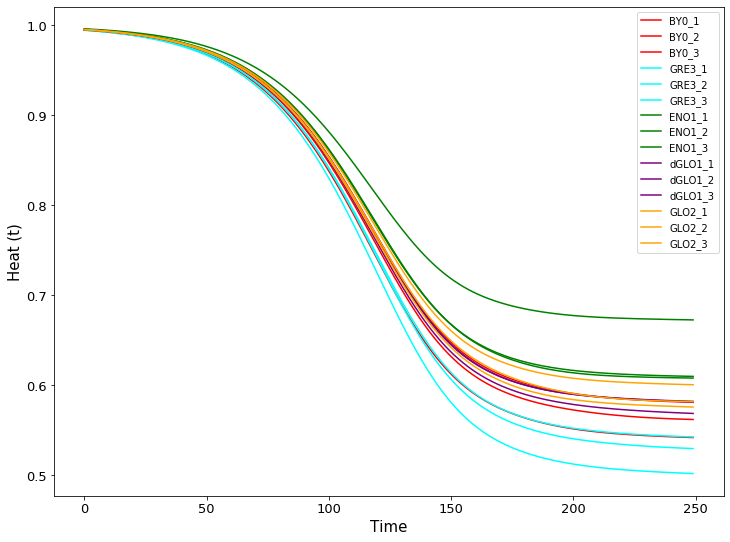

In [37]:
f, ax = plt.subplots(figsize=(12,9))
    
for i in G_heat:
    if i.startswith('BY'):
        plt.plot(G_heat[i], color = 'red')
    if i.startswith('GRE3'):
        plt.plot(G_heat[i], color = 'cyan')
    if i.startswith('ENO1'):
        plt.plot(G_heat[i], color = 'green')
    if i.startswith('dGLO1'):
        plt.plot(G_heat[i], color = 'purple')
    if i.startswith('GLO2'):
        plt.plot(G_heat[i], color = 'orange')
        
plt.xlabel('Time', fontsize=15)
plt.ylabel('Heat (t)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(G_heat.keys())
plt.show()


In [38]:
heat_df
#Non-condensed distance matrix between the different samples

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
BY0_1,0,0.20183,0.43612,0.417951,0.533319,0.843291,0.932809,0.258768,0.274034,0.0247543,0.0167284,0.133573,0.0131037,0.182218,0.0705553
BY0_2,0.20183,0,0.234584,0.216446,0.332339,0.641744,1.13446,0.460453,0.475284,0.186172,0.193291,0.0685056,0.208764,0.383505,0.132137
BY0_3,0.43612,0.234584,0,0.0317107,0.109391,0.409635,1.36788,0.694279,0.708537,0.419235,0.426862,0.302682,0.442915,0.616976,0.366009
GRE3_1,0.417951,0.216446,0.0317107,0,0.11746,0.425458,1.35046,0.676301,0.691222,0.401802,0.408874,0.284461,0.425071,0.599404,0.347962
GRE3_2,0.533319,0.332339,0.109391,0.11746,0,0.310657,1.4659,0.791614,0.807032,0.517924,0.524639,0.400236,0.540413,0.715125,0.463701
GRE3_3,0.843291,0.641744,0.409635,0.425458,0.310657,0,1.77587,1.10164,1.11667,0.827242,0.834291,0.709875,0.850307,1.02484,0.773381
ENO1_1,0.932809,1.13446,1.36788,1.35046,1.4659,1.77587,0,0.674338,0.659374,0.948808,0.941594,1.06614,0.926201,0.751084,1.0026
ENO1_2,0.258768,0.460453,0.694279,0.676301,0.791614,1.10164,0.674338,0,0.0235329,0.275173,0.267564,0.392053,0.252505,0.0779489,0.328468
ENO1_3,0.274034,0.475284,0.708537,0.691222,0.807032,1.11667,0.659374,0.0235329,0,0.289474,0.282437,0.406972,0.267651,0.0919369,0.343417
dGLO1_1,0.0247543,0.186172,0.419235,0.401802,0.517924,0.827242,0.948808,0.275173,0.289474,0,0.0114863,0.117963,0.0334901,0.197778,0.0550144


### GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4 node graphlets) - (Needs verification)

#### Very quick explanation

This methods considers 11 of the 15 possible orbits (since the other 4 are redundant - 3, 12, 13, 14) of 2 to 4-node graphlets - check image below. Nodes with the same colour in the same graphlet are 'automorphic' in the sense that it is the 'same' position.  5-node graphlets were excluded to diminish dependencies between graphlets which add noise (supposedly). With these orbits, we can build a Graphlet Degree Vector for each node that is composed by the number of times a node is present in each of the 11 types of orbits. This are the rows of a Dataframe with 11 columns (for one network). This is what the calculating_orbits function does (except it returns a dict of dicts instead of a dataframe).

From this dataframe, the spearman correlation between each pair of the 11 columns is calculated to generate a 11x11 matrix - the Graphlet Correlation Matrix (GCM). The GCM is symmetric so only one half of the matrix is informative. This, according to the authors, is the signature (summarized) of the network topology by this method (since networks with different kinds of connections/topologies will have different patterns of orbits and therefore correlations - stored in G_corrMat. The usual distance calculation between the different 'signatures' can then give the distance between the different networks which is ideal to build directly a dendrogram.

However, unlike what was done for the heat diffusion we don't want a distance matrix to be our dataset for supervised methods. So, a dataset was made where the GCM signature of each network was fully maintained by making a columns from the informative half of the GCM where each row has the name 'n-m' where n and m are the names of orbits and the value in that row is the spearman correlation between those two orbits in the network. This makes it so every network is reduced to a dataset of just 60 features that simbolize the topology of said network.


#### Note: This was fully developed by me from paper descriptions (which already is an alert signal). This means that I have no clue if everyhting is correctly applied (or if anything). I would like to have a basis to compare but it is not being easy to find. One that I found used a Linux file that I can't run and the results in one of the paper are from either artificial networks or networks they don't give free access too (to make sure it is equal).

Useful papers for detailed explanations: 
- Revealing the Hidden Language of Complex Networks - GCD-11 - probably the best one
- Uncovering Biological Network Function via Graphlet Degree Signatures - some details on graphlet signatures
- Comparing methods for comparing networks - many different methods

- Site with code to apply the GCD-11 distance (more reliable than me but has a Linux file, also needs network in .gw format but that should be easily workable (probably) - http://www0.cs.ucl.ac.uk/staff/natasa/GCD/

<img src="Graphlets.png" width="800">

In [39]:
G_CorrMat = {}
for i in G:
    #For 1 network
    orbits_t = calculating_orbits(G[i]) #Calculating orbit number for each node
    orbits_df = pd.DataFrame.from_dict(orbits_t).T #Transforming into a dataframe
    
    corrMat_ar = stats.spearmanr(orbits_df)[0] #Calculating spearman correlation to obtain 11x11 signature of the network - GCM.
    G_CorrMat[i] = np.triu(corrMat_ar) #Both parts of the matrix are equal, so reducing the info to the upper triangle.

In [40]:
G_CorrMat_df = {}
orbits = [0,1,2,4,5,6,7,8,9,10,11] #orbit names

for i in G_CorrMat:
    samp_col = {}
    for u in range(len(G_CorrMat[i])):
        for v in range(u+1, len(G_CorrMat[i])):
            samp_col[str(orbits[u]) + '-' + str(orbits[v])] = G_CorrMat[i][u,v]
        G_CorrMat_df[i] = samp_col
#Each row of the dataframe will be orbit_u-orbit_v correlation
corrMat_df = pd.DataFrame.from_dict(G_CorrMat_df)
corrMat_df

,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
0-1,0.928762,0.927232,0.912593,0.924125,0.948105,0.936241,0.902755,0.920761,0.913723,0.921031,0.923581,0.931646,0.923492,0.921283,0.930036
0-2,0.890029,0.890886,0.884809,0.904641,0.911555,0.920261,0.857024,0.882790,0.876031,0.891496,0.882319,0.903260,0.889593,0.895477,0.901810
0-4,0.887364,0.887087,0.874850,0.902333,0.912761,0.901439,0.843324,0.865062,0.863715,0.875233,0.873787,0.876174,0.880307,0.862646,0.865062
0-5,0.868370,0.873242,0.867419,0.894134,0.902037,0.903293,0.809980,0.844289,0.847531,0.861030,0.862623,0.872125,0.865627,0.865215,0.879221
0-6,0.802095,0.825422,0.811962,0.869338,0.875453,0.868642,0.788002,0.802234,0.800542,0.815684,0.826178,0.822441,0.818128,0.823070,0.812235
0-7,0.733157,0.737615,0.737820,0.766308,0.800511,0.801433,0.685475,0.722444,0.722705,0.750549,0.752663,0.740663,0.697843,0.703935,0.728777
0-8,0.712793,0.757503,0.745871,0.770125,0.793176,0.794172,0.715891,0.735100,0.743087,0.765409,0.738165,0.768613,0.723132,0.747890,0.733144
0-9,0.678380,0.714988,0.701879,0.731936,0.773934,0.760998,0.649865,0.679794,0.679170,0.751005,0.759854,0.732711,0.664854,0.675731,0.657534
0-10,0.623379,0.646200,0.621756,0.659564,0.706695,0.696390,0.555214,0.594287,0.603951,0.665924,0.679582,0.659587,0.573693,0.590588,0.579133
0-11,0.604782,0.631371,0.609718,0.652723,0.692363,0.683492,0.538087,0.590371,0.596237,0.657579,0.664608,0.653277,0.564907,0.578967,0.576583


##### Global metadata for consistency between tables and plots

Finally, only now are the labels of each group added making the dataframe a CDL Accessor.

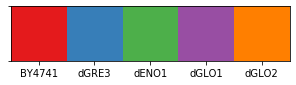

In [41]:
mtl.add_labels(degree_df, labels = labels)
mtl.add_labels(betw_df, labels = labels)
mtl.add_labels(closeness_df, labels = labels)
mtl.add_labels(groups_df, labels = labels)
mtl.add_labels(heat_df, labels = labels)
mtl.add_labels(corrMat_df, labels = labels)

sample_names = degree_df.cdl.samples
all_labels = degree_df.cdl.labels
unique_labels = degree_df.cdl.unique_labels

# customize these colors
#colours = cm.get_cmap('nipy_spectral', 5)(range(5))
colours = sns.color_palette('Set1', 9)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

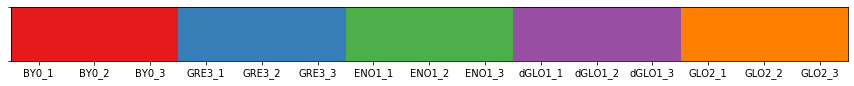

In [42]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

In [43]:
#Example of a centrality measure dataframe
degree_df

label          BY4741              dGRE3                dENO1                \
                BY0_1 BY0_2 BY0_3 GRE3_1 GRE3_2 GRE3_3 ENO1_1 ENO1_2 ENO1_3   
C11H23NO2        1.20   1.2  1.20   2.20    2.2    2.2    1.2    1.2    1.2   
C4H10O3S3        1.50   0.0  1.50   0.00    0.0    0.0    0.0    0.0    0.0   
C9H17NO4         2.00   2.0  1.50   1.50    0.5    0.5    0.5    1.5    0.5   
C8H17N3O3        1.75   0.5  0.75   0.75    1.5    0.5    0.0    0.0    0.0   
C6H10N2S3        0.20   0.2  0.20   0.00    0.0    0.0    0.0    0.0    0.0   
...               ...   ...   ...    ...    ...    ...    ...    ...    ...   
C20H9N13S6       0.00   0.0  0.00   0.00    0.0    0.0    0.0    0.0    0.0   
C26H23N7O7S3     0.00   0.0  0.00   0.00    0.0    0.0    0.0    0.0    0.0   
C20H22N12O9S2    0.00   0.0  0.00   0.00    0.0    0.0    0.0    0.0    0.0   
C18H44N8OS9      0.00   0.0  0.00   0.00    0.0    0.0    0.0    0.0    0.0   
C20H17N2O13PS5   0.00   0.0  0.00   0.00    0.0    0.0    0.0    0.0    0.0   

label            dGLO1                  dGLO2                
               dGLO1_1 dGLO1_2 dGLO1_3 GLO2_1 GLO2_2 GLO2_3  
C11H23NO2          1.2     1.2     1.2   1.20    1.2   1.20  
C4H10O3S3          0.0     0.0     0.0   0.00    0.0   0.00  
C9H17NO4           1.5     1.5     1.5   0.50    0.5   0.50  
C8H17N3O3          0.0     0.0     0.0   0.25    0.0   0.75  
C6H10N2S3          0.0     0.0     0.0   0.00    0.0   0.00  
...                ...     ...     ...    ...    ...    ...  
C20H9N13S6         0.0     0.0     0.0   0.00    0.0   0.00  
C26H23N7O7S3       0.0     0.0     0.0   0.00    0.0   0.00  
C20H22N12O9S2      0.0     0.0     0.0   0.00    1.0   1.00  
C18H44N8OS9        0.0     0.0     0.0   0.00    0.0   0.00  
C20H17N2O13PS5     0.0     0.0     0.0   0.00    0.0   0.00  

[1528 rows x 15 columns]

### Hierarchical Cluster Analysis (agglomerative)

HCA analysis and plotting 7 dendrograms based on the 6 dataframes built - degree, betweenness centrality, closeness centrality, sum of the 3 prior distance matrices, group influence, heat diffusion (already a distance matrix in this case, the distance matrix is used since no better option is available) and GCD-11.

In [44]:
def plot_dendogram(Z, title=''):
    fig = plt.figure(figsize=(14,7))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=12, above_threshold_color='b')
    #Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

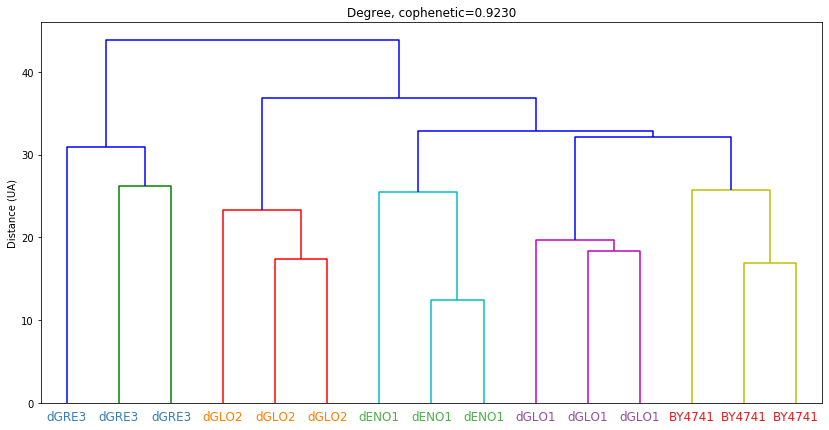

In [45]:
degree_df_dist = dist.pdist(degree_df.T, metric='euclidean')
#degree_df_jdist = dist.pdist(degree_df.T, metric='jaccard')
Z_degree = hier.linkage(degree_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_degree, degree_df_dist)[0]

title = f'Degree, cophenetic={coph:.4f}'
plot_dendogram(Z_degree, title)

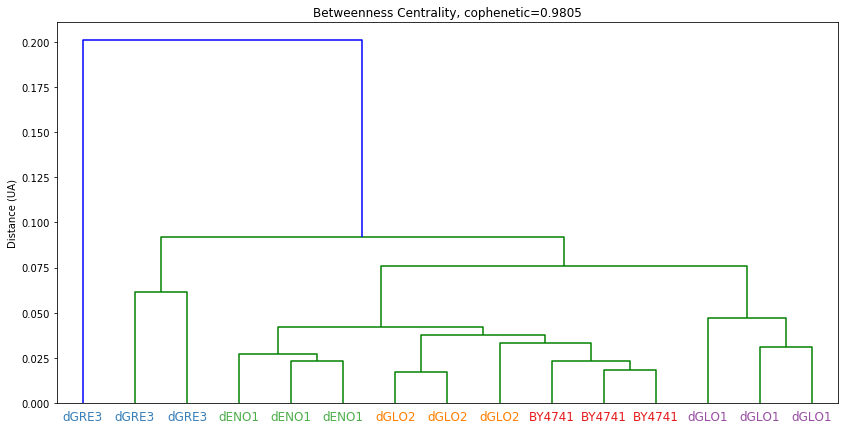

In [46]:
betw_df_dist = dist.pdist(betw_df.T, metric='euclidean')
#betw_df_jdist = dist.pdist(betw_df.T, metric='jaccard')
Z_betw = hier.linkage(betw_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_betw, betw_df_dist)[0]

title = f'Betweenness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z_betw, title)

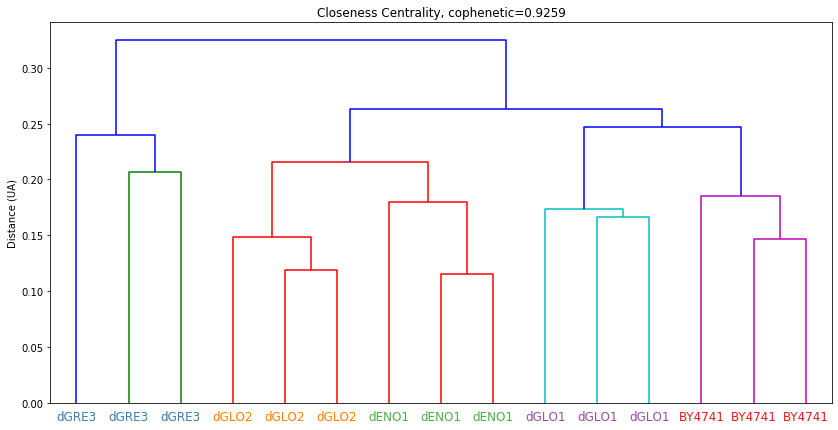

In [47]:
closeness_df_dist = dist.pdist(closeness_df.T, metric='euclidean')
#closeness_df_jdist = dist.pdist(closeness_df.T, metric='jaccard')
Z_closeness = hier.linkage(closeness_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_closeness, closeness_df_dist)[0]

title = f'Closeness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z_closeness, title)

Summing all the distances between the different sample with the 3 centrality measures

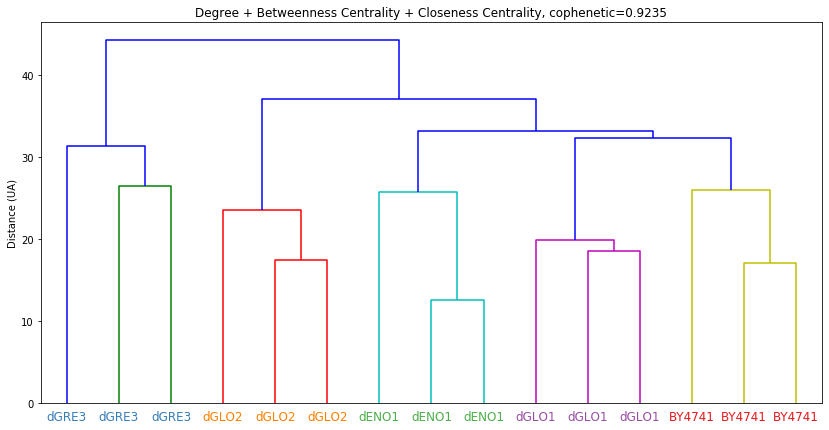

In [48]:
all_df_dist = degree_df_dist + betw_df_dist + closeness_df_dist
Z = hier.linkage(all_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z, all_df_dist)[0] #method average seems to lead to higher coefficients

title = f'Degree + Betweenness Centrality + Closeness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z, title)

Group Influence dendrogram

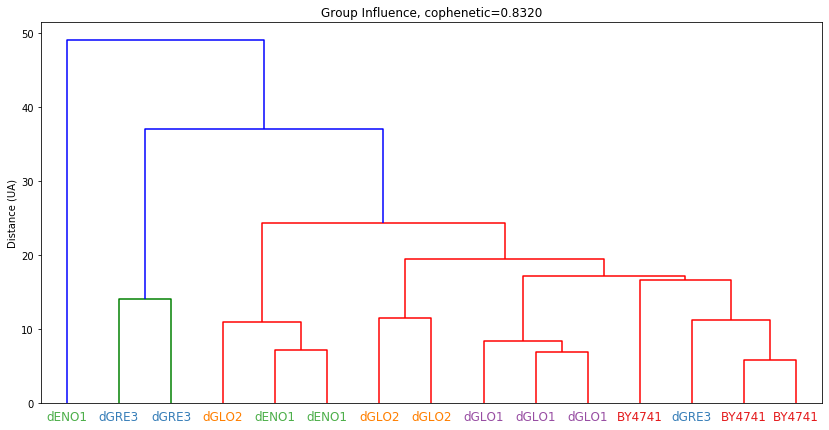

In [49]:
groups_df_dist = dist.pdist(groups_df.T, metric='euclidean')
Z_groups = hier.linkage(groups_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_groups, groups_df_dist)[0] #method average seems to lead to higher coefficients

title = f'Group Influence, cophenetic={coph:.4f}'
plot_dendogram(Z_groups, title)

Heat Diffusion Dendrogram

In [50]:
heat_df_short = dist.squareform(heat_df) #Condensing the distance matrix
#Be careful when running these 3 cells, running them weirdly can lead to kernel dying for unknown reasons.

In [51]:
Z_heat = hier.linkage(heat_df_short, method='average')

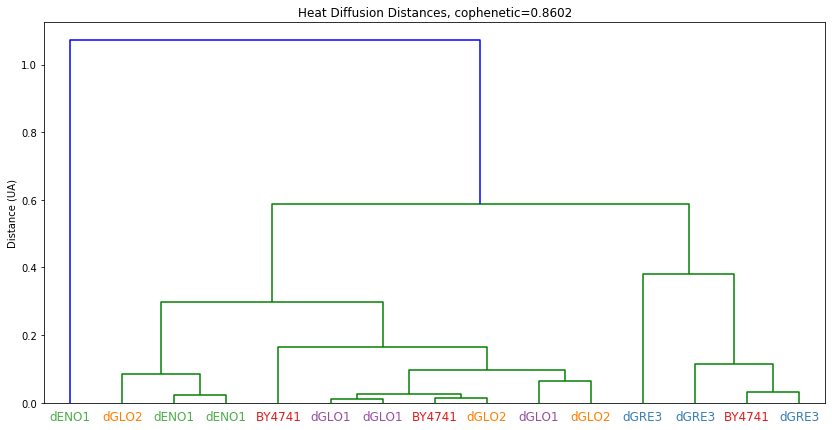

In [52]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_heat, heat_df_short)[0] #method average seems to lead to higher coefficients

title = f'Heat Diffusion Distances, cophenetic={coph:.4f}'
plot_dendogram(Z_heat, title)

GCD-11 dendrogram

In [53]:
#Calculating distances between samples

#Both ways are equal - 2nd you get the condensed distance matrix right away

#1st way
#corrMat_df_dist = pd.DataFrame(index=G_CorrMat.keys(), columns=G_CorrMat.keys())

#for g in G_CorrMat:
#    for i in G_CorrMat:
#        corrMat_df_dist.loc[g,i] = np.linalg.norm(G_CorrMat[g]-G_CorrMat[i])
#corrMat_df_dist

#2nd way
corrMat_df_dist = dist.pdist(corrMat_df.T)

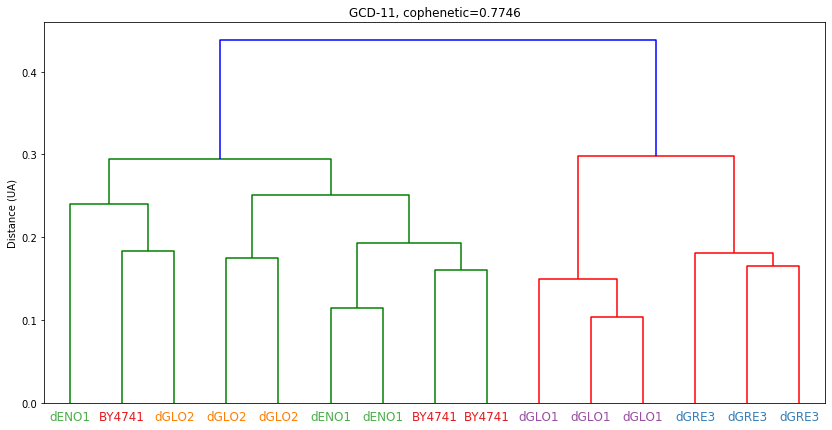

In [54]:
Z_GCD = hier.linkage(corrMat_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_GCD, corrMat_df_dist)[0] #method average seems to lead to higher coefficients

title = f'GCD-11, cophenetic={coph:.4f}'
plot_dendogram(Z_GCD, title)

### Comparing HCA Discrimination

In [55]:
Z = (Z_degree, Z_betw, Z_closeness, Z_groups, Z_heat, Z_GCD)
dists = (degree_df_dist, betw_df_dist, closeness_df_dist, groups_df_dist, heat_df_short, corrMat_df_dist)

colnames = ['Degree', 'Betweenness', ' Closeness', 'Group Influence', 'Heat Diffusion', 'GCD-11']

In [56]:
disc_average = np.zeros((1,6))
disc_median = np.zeros((1,6))
disc_correct = np.zeros((1,6))
disc_goodclust = np.zeros((1,6))

for i in range(len(Z)):
    data = degree_df
    discrim = ma.dist_discrim(data, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.dist_discrim(data, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
    disc_goodclust[0,i] = ma.good_first_cluster_fraction(data, Z[i]) #all samples have the same order
    
#Transforming results into DataFrames    
disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)
disc_goodclust = pd.DataFrame(disc_goodclust, index = ['% good 1st cluster'], columns = colnames)

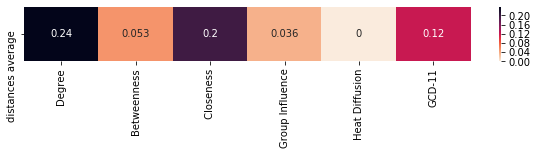

In [57]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

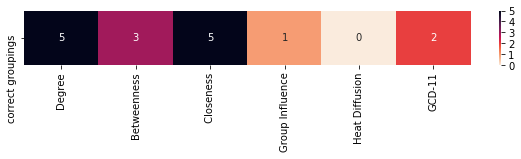

In [58]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

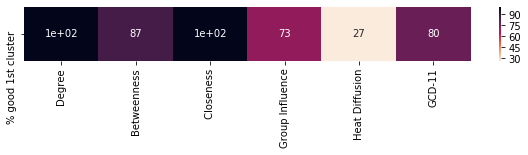

In [59]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_goodclust*100, annot=True, ax=ax, cmap = sns.cm.rocket_r)

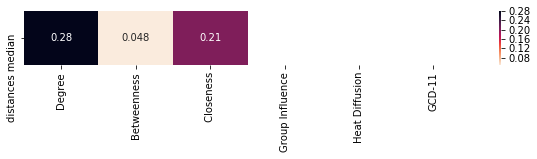

In [60]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means clustering

In [61]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [62]:
Kmean = skclust.KMeans(n_clusters=5)

In [63]:
a = Kmean.fit(degree_df.T)
a = Kmean.fit(corrMat_df.T)
a.inertia_

0.16185826930591496

In [64]:
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{2: ['BY4741', 'dENO1', 'dGLO2'],
 1: ['BY4741', 'BY4741', 'dENO1', 'dENO1'],
 3: ['dGRE3', 'dGRE3', 'dGRE3'],
 0: ['dGLO1', 'dGLO1', 'dGLO1'],
 4: ['dGLO2', 'dGLO2']}

### K-means clustering applied to all networks

Use of the `Kmeans_discrim` function from multianalysis to calculate the different metrics.

In [65]:
Data = (degree_df, betw_df, closeness_df, groups_df, heat_df, corrMat_df)

In [66]:
disc_average = np.zeros((1,6))
#disc_median = np.zeros((1,6))
disc_correct = np.zeros((1,6))
disc_rand = np.zeros((1,6))

for i in range(len(Data)):
    discrim = ma.Kmeans_discrim(Data[i], method = 'average', iter_num=150, best_fraction=0.1)
    
    #Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    for j in discrim:
        average.append(discrim[j][0]) #Discrimination Distances
        all_correct = np.array(list(discrim[j][1].values()))
        correct.append(len(all_correct[all_correct>0])) #Correct Clustering Percentages
        rand.append(discrim[j][2]) #Rand Index
    
    #Putting results into the arrays - median of the best k-means clustering
    disc_average[0,i] = np.median(average) 
    disc_correct[0,i] = np.median(correct)
    disc_rand[0,i] = np.median(rand)

#Transforming into DataFrame
disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct/5*100, index = ['correct groupings'], columns = colnames)
disc_rand = pd.DataFrame(disc_rand, index = ['correct groupings'], columns = colnames)

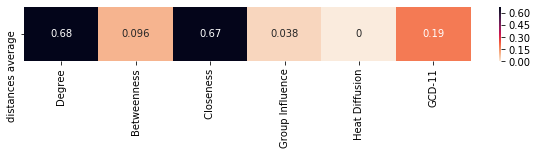

In [67]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

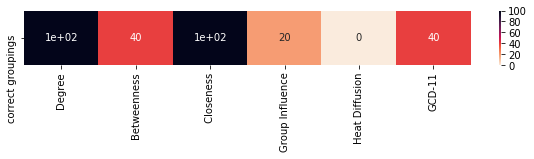

In [68]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

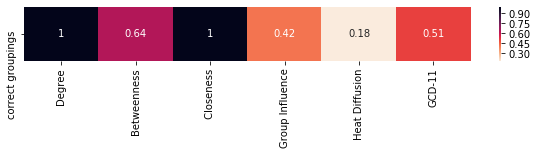

In [69]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_rand, annot=True, ax=ax, cmap = sns.cm.rocket_r)

In [70]:
#f, ax = plt.subplots(figsize=(10, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

## Supervised analysis

#### The datasets that will be analyzed:

In [71]:
datasets = {'degree': degree_df, 'betweenness': betw_df, 'closeness' : closeness_df, 'groups': groups_df, 'heat_dif': heat_df,
           'GCD-11': corrMat_df}

### Test number of trees needed for convergence for N, NP, NGP and binary data (both alignments)

In [72]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,400,10)}

rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv =3)

In [73]:
param = []
test_score = []
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting degree ... Done!
Fitting betweenness ... Done!
Fitting closeness ... Done!
Fitting groups ... Done!
Fitting heat_dif ... Done!
Fitting GCD-11 ... Done!


Performance based on number of trees - Alignment: 1-2, Negative Mode


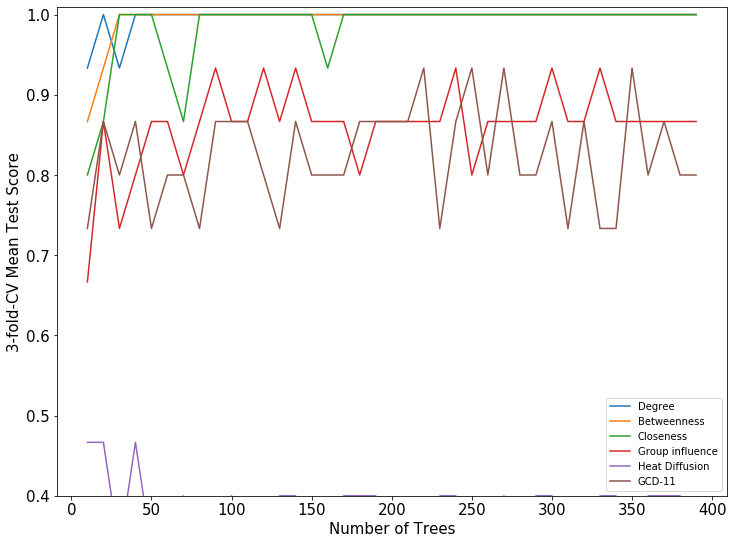

In [74]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(6):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('Degree', 'Betweenness', 'Closeness', 'Group influence', 'Heat Diffusion', 'GCD-11'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 1-2, Negative Mode')

### Random Forests

Application of the Random Forests

In [75]:
# Preparations of dicts:
Scores = {}
Scores_std = {}
Imp_feat = {}

for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data)
    #, iter_num = 100) #(Scores, Cohen's Kappa Score, order of features based on importances, 3-fold cross-validation)
    Scores[name] = rf
    Scores_std[name] = np.std(rf)
    Imp_feat[name] = imp_features
    print(f'done')    

Fitting random forest for degree ...done
Fitting random forest for betweenness ...done
Fitting random forest for closeness ...done
Fitting random forest for groups ...done
Fitting random forest for heat_dif ...done
Fitting random forest for GCD-11 ...done


Performance of each predictive model

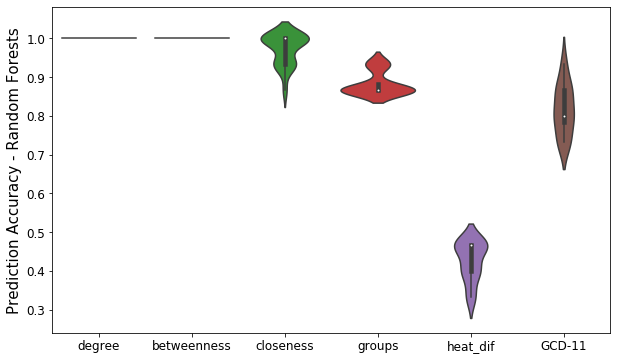

In [76]:
f, ax = plt.subplots(figsize=(10,6))
data = pd.DataFrame.from_dict(Scores)
sns.violinplot(data = data,  alpha = 0.5) #palette = colors*2,
plt.ylabel('Prediction Accuracy - Random Forests', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)

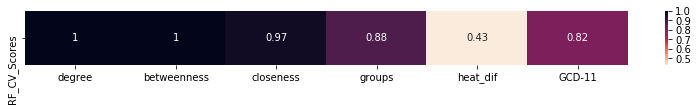

In [77]:
Scores_A = {}
for i in Scores:
    Scores_A[i] = np.mean(Scores[i])

Scores_H = pd.DataFrame(list(Scores_A.values()), index = Scores_A.keys()).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])

In [78]:
Imp_feat['groups'] #Important groups whose influence can be characteristic of each network - again S and CONH don't contribute

[(10, 0.0945250586861641, 'PO3H'),
 (13, 0.08196387979809198, 'CO'),
 (0, 0.07992175101287348, 'H2'),
 (5, 0.07523435467856564, 'NCH'),
 (4, 0.06899031618338335, 'CHOH'),
 (9, 0.06864402936259957, 'CONH'),
 (3, 0.06703572206417042, 'O'),
 (1, 0.06472562244857588, 'CH2'),
 (11, 0.06149337955873566, 'NH3(-O)'),
 (14, 0.05909968307062642, 'C2H2O'),
 (6, 0.05366651787260822, 'O(-NH)'),
 (7, 0.052501984229220366, 'OH'),
 (15, 0.04787802793255052, 'H2O'),
 (2, 0.04718524663085292, 'CO2'),
 (8, 0.045495620704366906, 'S'),
 (12, 0.03163880576661457, 'SO3')]

#### Extracting a single decision tree

Decision Tree


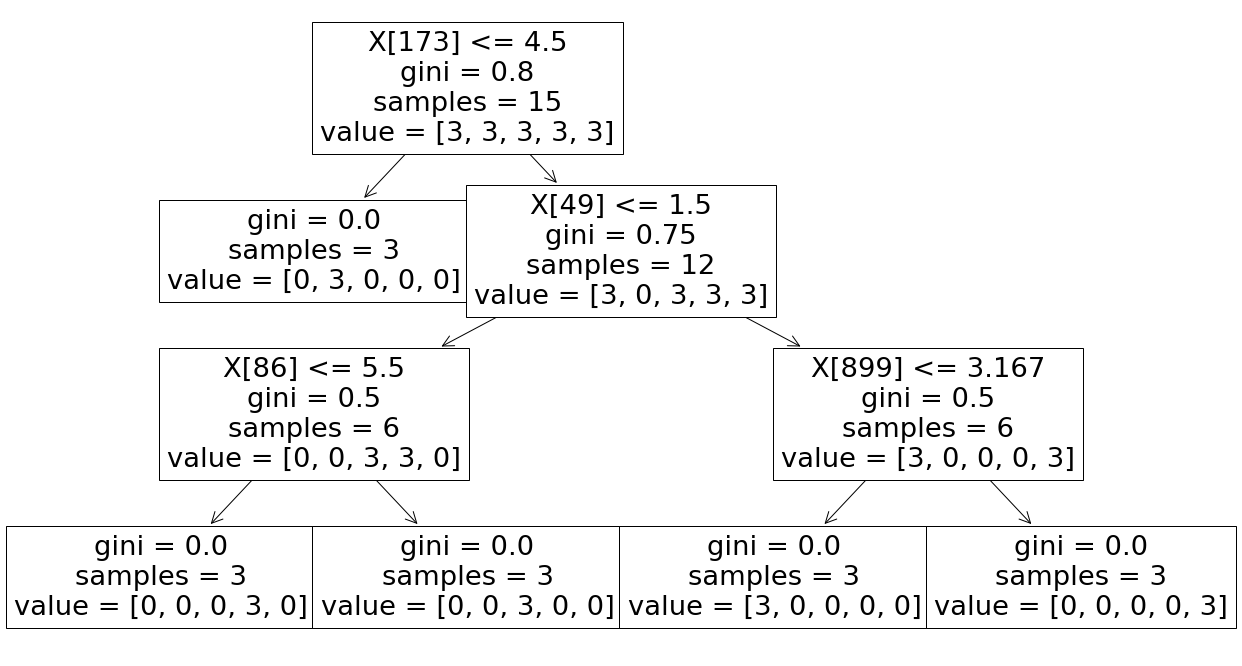

In [79]:
from sklearn.model_selection import train_test_split
import sklearn.ensemble as skensemble
X_train, X_test, y_train, y_test = train_test_split(datasets['degree'].T, all_labels, test_size=1/3)
rf = skensemble.RandomForestClassifier(n_estimators = 200)
#rf.fit(X_train, y_train)
rf.fit(datasets['degree'].T, all_labels)

from sklearn import tree
fig = plt.figure(figsize=(22,12))
#clf = rf.estimators_[2].fit(X_train, y_train)
clf = rf.estimators_[2].fit(datasets['degree'].T, all_labels)
tree.plot_tree(clf)
print('Decision Tree')

### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

All analysis is simialr to the ones performed in similarity_analysis notebooks

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [80]:
matrix = pd.get_dummies(all_labels)
matrix

,BY4741,dENO1,dGLO1,dGLO2,dGRE3
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,0,1
6,0,1,0,0,0
7,0,1,0,0,0
8,0,1,0,0,0
9,0,0,1,0,0


#### Search for the best number of components to use

In [81]:
%%capture --no-stdout
PLS_optim = {}
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 10)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for degree ...done
Optimizing PLS-DA for betweenness ...done
Optimizing PLS-DA for closeness ...done
Optimizing PLS-DA for groups ...done
Optimizing PLS-DA for heat_dif ...done
Optimizing PLS-DA for GCD-11 ...done


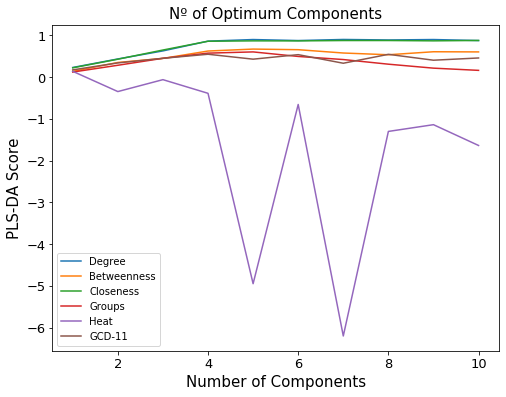

In [82]:
f, ax = plt.subplots(figsize=(8,6))


for name, data in PLS_optim.items():
    plt.plot(range(1,11),data)
    
plt.xlabel('Number of Components', fontsize=15)
plt.ylabel('PLS-DA Score', fontsize=15)
plt.title('Nº of Optimum Components', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(('Degree', 'Betweenness', 'Closeness', 'Groups', 'Heat', 'GCD-11'))
plt.show()

#### Application of PLS-DA

In [83]:
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [84]:
%%capture --no-stdout

for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 5, iter_num = 100, feat_type = 'Coef')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done') 

Fitting PLS-DA for degree ...done
Fitting PLS-DA for betweenness ...done
Fitting PLS-DA for closeness ...done
Fitting PLS-DA for groups ...done
Fitting PLS-DA for heat_dif ...done
Fitting PLS-DA for GCD-11 ...done


Accuracy based on the dataset


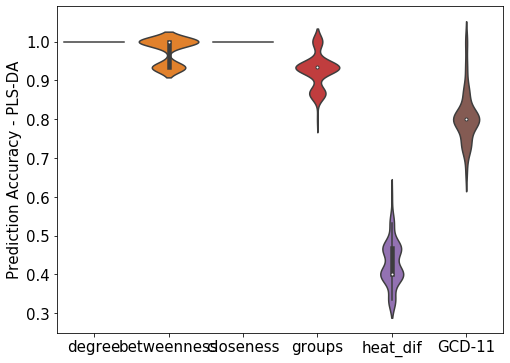

In [85]:
f, ax = plt.subplots(figsize=(8,6))
sns.violinplot(data=pd.DataFrame.from_dict(PLS_accu), alpha = 0.5)#palette = colors, 
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 15)
print('Accuracy based on the dataset')

In [86]:
Accuracy = {}
Score = {}
Accuracy_std = {}
Score_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.mean(PLS_accu[name])
    Score[name] = np.mean(PLS_score[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])
    Score_std[name] = np.std(PLS_score[name])

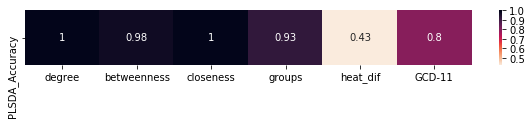

In [87]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T

f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])
plt.show()

In [88]:
PLS_feat['groups'] #s and CONH still useless. The main contriuting groups are different from the ones in Random Forests.

[(5, 0.21146157629145101, 'NCH'),
 (0, 0.14027040835709734, 'H2'),
 (14, 0.13722153272831977, 'C2H2O'),
 (2, 0.1358470429558201, 'CO2'),
 (3, 0.13417500583927633, 'O'),
 (9, 0.13339656527848595, 'CONH'),
 (11, 0.120345368378256, 'NH3(-O)'),
 (10, 0.1171730646090389, 'PO3H'),
 (13, 0.11054555571114055, 'CO'),
 (4, 0.10861249875256862, 'CHOH'),
 (15, 0.09395476720894988, 'H2O'),
 (1, 0.07374215341223186, 'CH2'),
 (7, 0.070311997841605, 'OH'),
 (6, 0.06741482977095371, 'O(-NH)'),
 (8, 0.05525408103368218, 'S'),
 (12, 0.052658504519992, 'SO3')]

## Some fast conclusions:

- Using betweeness centrality and closeness centrality leads to near 100% perfect discrimination between the different strains although it doesn't quite reach 100% even after all of the simplification made on the original dataset.
- Degree as a centrality measure performs worse than the other two, having a 90% accuracy on both predictive models and not complete discrimination with HCA.
- Group influence performs surprisingly well and very similar (slightly slightly worse) to degree (with even more limited information). We can also surmise that 2 groups are currently not being helpful in establishing networks and that the most important groups for Random Forests and PLS-DA varies.
- Heat diffusion performs poorly with all types of analysis, which would mean it is not a good way to analyse the data or that the analysis isn't being well performed (or both). knn analysis as was done in the link that talked about heat diffusion seems difficult to do in this case due to the low amount of replicates.

#### Model with the full dataset and sample representation on the two most important Components/Latent Variables

In [89]:
from sklearn.cross_decomposition import PLSRegression

In [90]:
def plot_PLSDA(principaldf, label_colors, components=(1,2), title="PLS-DA", ax=None):
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    with sns.axes_style("whitegrid"):
        #ax.axis('equal')
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

        unique_labels = principaldf['Label'].unique()

        for lbl in unique_labels:
            subset = principaldf[principaldf['Label']==lbl]
            ax.scatter(subset[col_c1_name],
                       subset[col_c2_name],
                       s=50, color=label_colors[lbl], label=lbl)

        ax.legend(framealpha=1, fontsize='large')
        ax.set_title(title, fontsize=15)

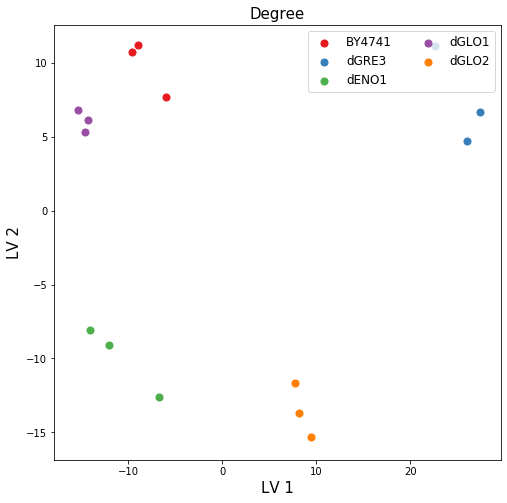

In [91]:
n_components = 5

plsreg = ma.PLSscores_with_labels(degree_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="Degree", ax=axl)
plt.legend(loc='upper right', ncol=2, fontsize=12)
plt.show()

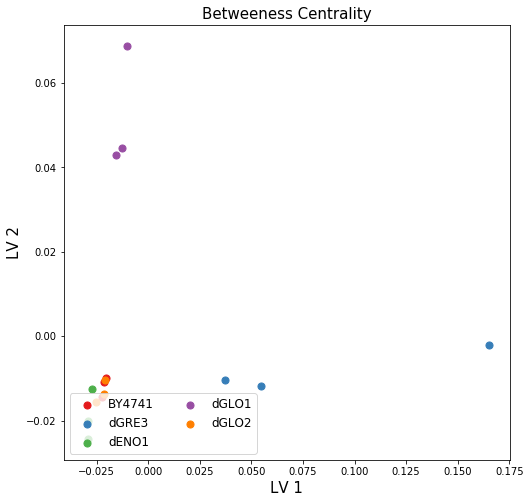

In [92]:
n_components = 5

plsreg = ma.PLSscores_with_labels(betw_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="Betweeness Centrality", ax=axl)
plt.legend(loc='lower left', ncol=2, fontsize=12)
plt.show()

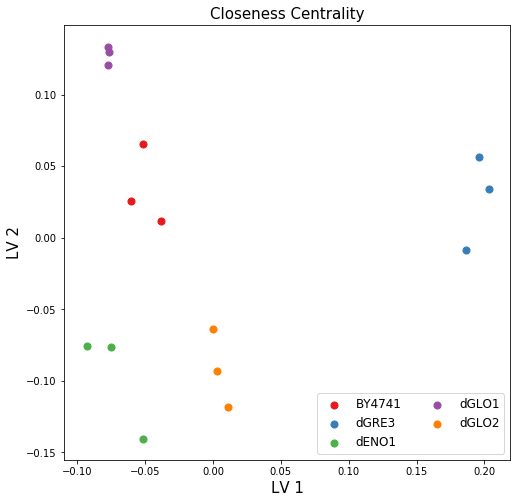

In [93]:
n_components = 5

plsreg = ma.PLSscores_with_labels(closeness_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="Closeness Centrality", ax=axl)
plt.legend(loc='lower right', ncol=2, fontsize=12)
plt.show()

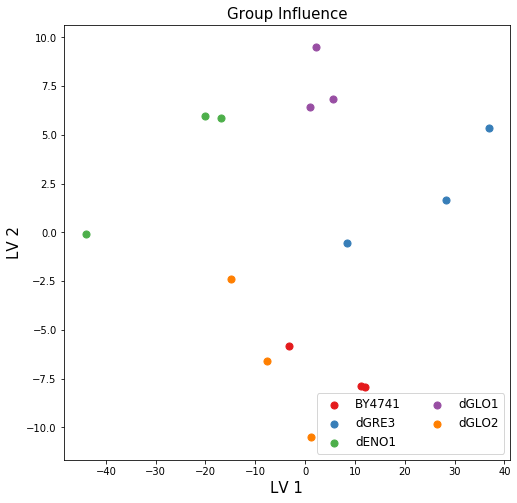

In [94]:
n_components = 2

plsreg = ma.PLSscores_with_labels(groups_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="Group Influence", ax=axl)
plt.legend(loc='lower right', ncol=2, fontsize=12)
plt.show()

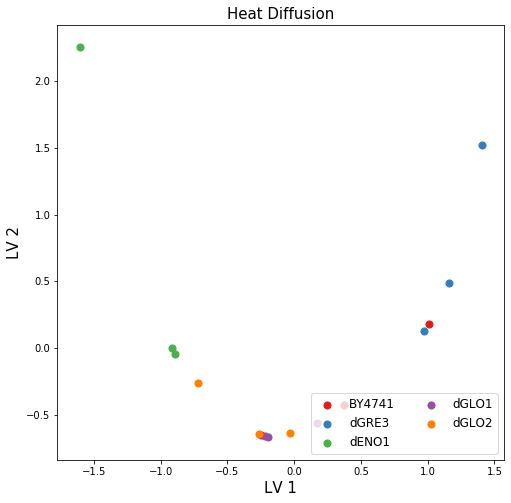

In [95]:
n_components = 2

plsreg = ma.PLSscores_with_labels(heat_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="Heat Diffusion", ax=axl)
plt.legend(loc='lower right', ncol=2, fontsize=12)
plt.show()

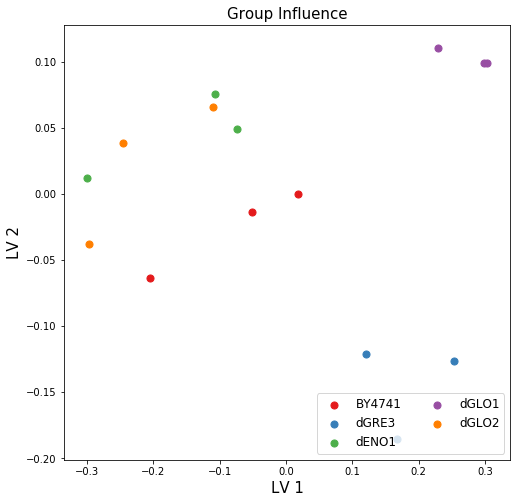

In [96]:
n_components = 2

plsreg = ma.PLSscores_with_labels(corrMat_df, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PLSDA(plsreg, label_colors, title="Group Influence", ax=axl)
plt.legend(loc='lower right', ncol=2, fontsize=12)
plt.show()

### Permutation Tests - PLS-DA

In [97]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

all_data = (degree_df, betw_df, closeness_df, groups_df, heat_df, corrMat_df)
names = ('Degree', 'Betweenness', 'Closeness', 'Groups', 'Heat', 'GCD-11')
for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp=5, iter_num=150)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for Degree ...
Done!
permutation test (PLS-DA) for Betweenness ...
Done!
permutation test (PLS-DA) for Closeness ...
Done!
permutation test (PLS-DA) for Groups ...
Done!
permutation test (PLS-DA) for Heat ...
Done!
permutation test (PLS-DA) for GCD-11 ...
Done!


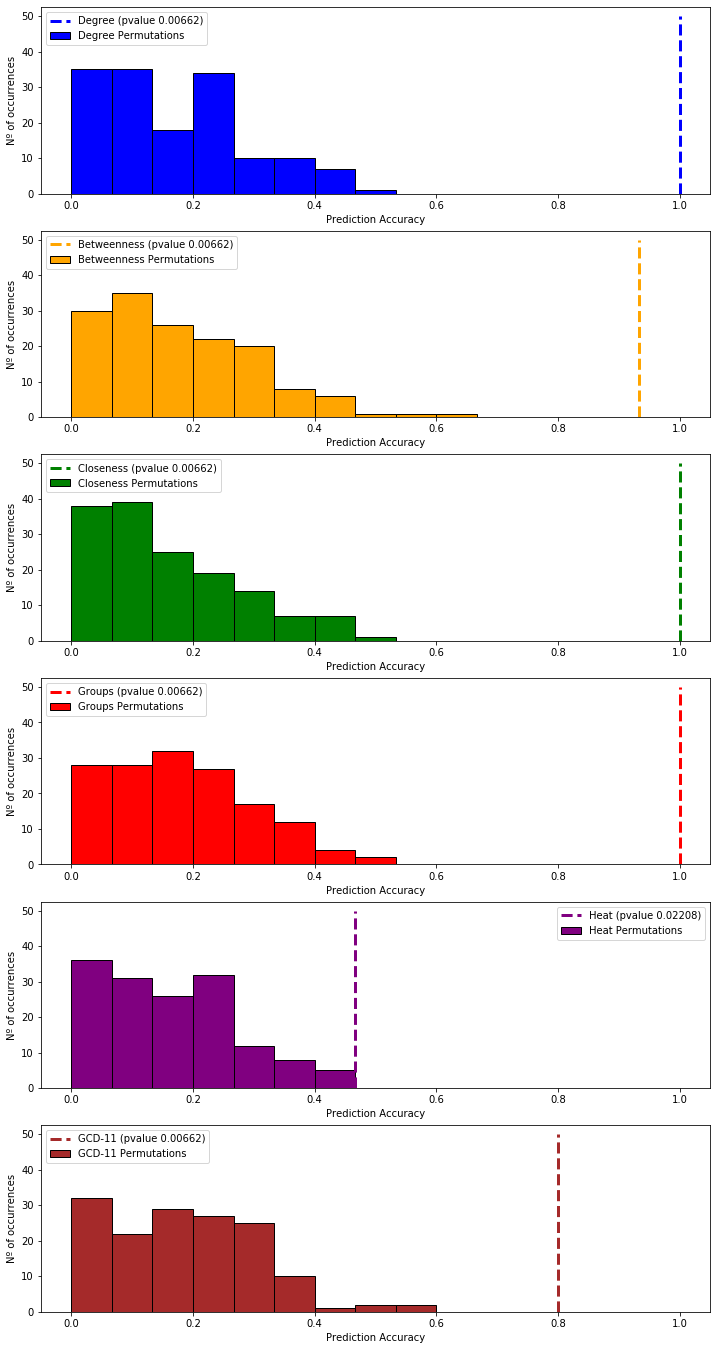

In [98]:
f, axes = plt.subplots(6, 1, figsize = (12,24))

Names = ['Degree', 'Betweenness', 'Closeness', 'Groups', 'Heat', 'GCD-11']
colors = ['blue','orange', 'green', 'red', 'purple', 'brown']
quadrant = [axes[0], axes[1], axes[2], axes[3], axes[4], axes[5]]
ylim = [0,50]
n_labels = len(degree_df.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Permutation Tests - Random Forests

In [99]:
CV = {}
PMs = {}
pvalue = {}

all_data = (degree_df, betw_df, closeness_df, groups_df, heat_df, corrMat_df)
names = ('Degree', 'Betweenness', 'Closeness', 'Groups', 'Heat', 'GCD-11')

for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for Degree ...
Done!
Permutation test (Random Forest) for Betweenness ...
Done!
Permutation test (Random Forest) for Closeness ...
Done!
Permutation test (Random Forest) for Groups ...
Done!
Permutation test (Random Forest) for Heat ...
Done!
Permutation test (Random Forest) for GCD-11 ...
Done!


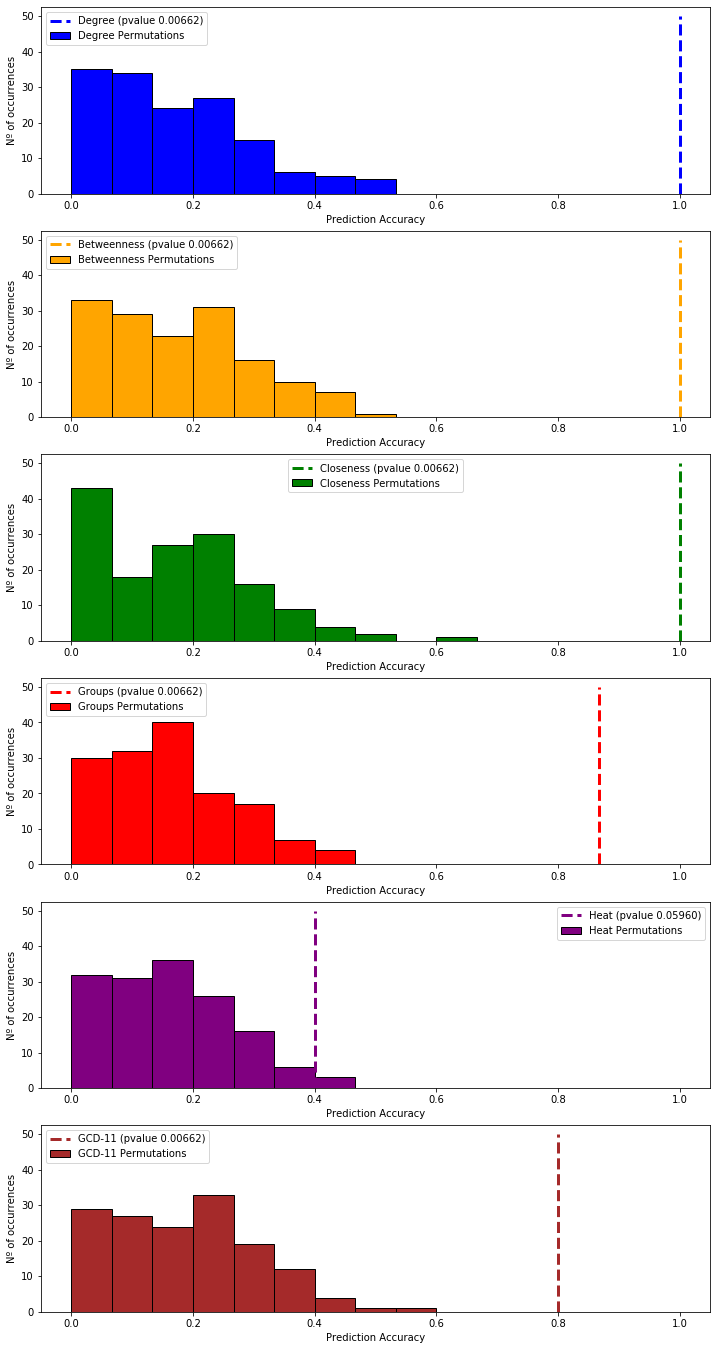

In [100]:
f, axes = plt.subplots(6, 1, figsize = (12,24))

Names = ['Degree', 'Betweenness', 'Closeness', 'Groups', 'Heat', 'GCD-11']
colors = ['blue','orange', 'green', 'red', 'purple', 'brown']
quadrant = [axes[0], axes[1], axes[2], axes[3], axes[4], axes[5]]
ylim = [0,50]
n_labels = len(degree_df.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Full yeast dataset graph

Make the graph considering all formulas that are in the dataset (that appear in at least 2 samples)

In [101]:
formula_df = deformulator(yeast_df)
formula_df.index = yeast_df['Formula']
formula_df

,C,H,O,N,S,P
Formula,,,,,,
C12H24O2,12.0,24.0,2.0,0.0,0.0,0.0
C11H23NO2,11.0,23.0,2.0,1.0,0.0,0.0
C4H10O3S3,4.0,10.0,3.0,0.0,3.0,0.0
C9H17NO4,9.0,17.0,4.0,1.0,0.0,0.0
C8H17N3O3,8.0,17.0,3.0,3.0,0.0,0.0
...,...,...,...,...,...,...
C20H44N8O3S11,20.0,44.0,3.0,8.0,11.0,0.0
C38H40N2O5S6,38.0,40.0,5.0,2.0,6.0,0.0
C27H68N6O10S5,27.0,68.0,10.0,6.0,5.0,0.0


In [102]:
Gr = nx.Graph()
Gr.add_nodes_from(formula_df.index)

In [103]:
edge_assembler(formula_df,Gr,depth=1)
inverse_weight_attributer(Gr)

In [104]:
l = BY2
l.index = l['Formula']
#Select all the formulas that appear in a certain sample (in this case, replicate nº2 of the BY strain) and represent them with
#a different color to see its distribution.

In [105]:
color_map = []
for node in Gr:
    if node in l.index:#BY2['Formula']:
        color_map.append('red') 
    else: 
        color_map.append('blue')
edge_colors =  [group_colors[lbl] for lbl in nx.get_edge_attributes(Gr,'group').values()]

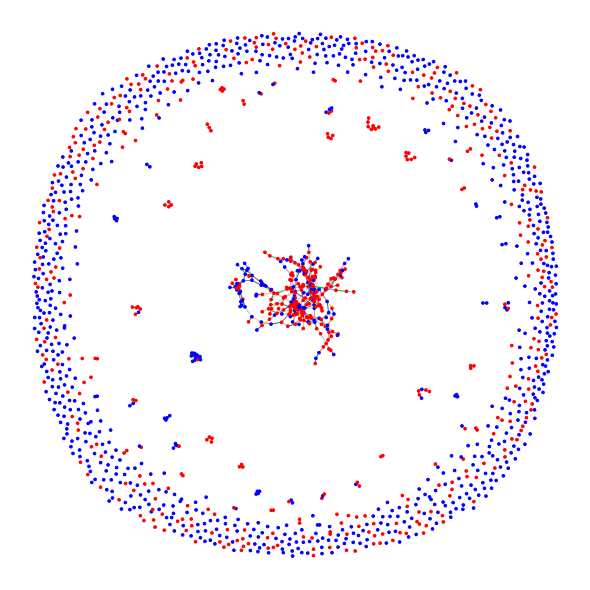

In [106]:
plt.figure(figsize=(8,8))
nx.draw(Gr, node_color=color_map, node_size=7, edge_color=edge_colors)
plt.show()

In [107]:
[len(c) for c in sorted(nx.connected_components(Gr), key=len, reverse=True)][:20]

[263, 14, 12, 8, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3]

In [108]:
len(Gr.edges())
#len(Gr.nodes())

665

In [109]:
#Group Influence in building the network
BY2_groups = dict.fromkeys(unique_group, 0)
for i in Gr.edges():
    BY2_groups[Gr.edges()[i]['group']] = BY2_groups[Gr.edges()[i]['group']] + Gr.edges()[i]['weight_inv']
BY2_groups

{'H2': 84.0,
 'CH2': 122.0,
 'CO2': 35.0,
 'O': 85.0,
 'CHOH': 62.0,
 'NCH': 21.0,
 'O(-NH)': 19.0,
 'OH': 0,
 'S': 5.0,
 'CONH': 14.0,
 'PO3H': 25.0,
 'NH3(-O)': 26.0,
 'SO3': 6.0,
 'CO': 49.0,
 'C2H2O': 42.0,
 'H2O': 70.0}

In [110]:
a = 0
for i in BY2_groups.values():
    a = a + i
a

665.0

Induce the subgraph of the formulas that appear in the sample from the graph of the full dataset

In [111]:
BY2 = yeast_df[yeast_df.iloc[:,4] != 0]

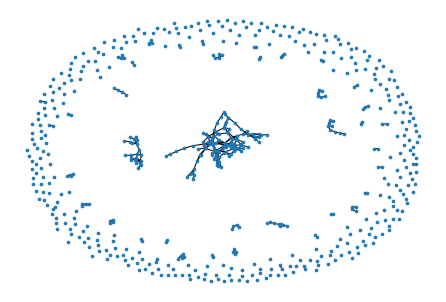

In [112]:
aaa = Gr.subgraph(BY2['Formula'])
nx.draw(aaa, node_size=7)
plt.show()

In [113]:
[len(c) for c in sorted(nx.connected_components(aaa), key=len, reverse=True)][:20]

[115, 22, 9, 8, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 2]

Conclusion: A stagerring amount of nodes remain connected and the biggest components with 136 nodes is almost identical to the one made straight from just the sample formulas (that reached 138 formulas).

'CONH' groups doesn't establish almost any connection, 'S' also establishes a low amount of connections, followed by 'SO3' and 'OH'.

### A lot more analysis with Average Size of Networks, Contributions of different groups to the Networks, Heat Diffusion, etc.

### To Do:

- Edit groups and see more groups in BRENDA - Done for now
- Use Group_influence - Kinda 50% done? Not great results
- Explain extensions made - Done
- Implement Shakespear Heat diffusion - Done
- Ameliorate analysis overall - inclusion of average size of networks
- Try idea of induced subgraphs
- Better presentation especially on edge_assembler? Maybe implement something that you can just say the groups and the function will adapt accordingly - possible using formula_process function most likely, would it be worth the slight decrease in time (probable small in comparison with the time it takes) - In process

### Old edge_assembler

In [114]:
def edge_assembler(formula_df, G):
    """Add all wanted possible edges to the formula network created and return a dictionary of the influence of each group
    in establishing the edges."""
    
    groups = ['H2','CH2','CO2','O','PH3','SH2','NH2','OH','SH','PH2','PO3H','NH3(-O)','SO3','CO']
    group_influence = dict.fromkeys(groups,0)
    
    for i in formula_df.index:
        node = formula_df.loc[i]
        
        #H2
        weight = edge_finder(G, formula_df, node, h=2)
        #print(weight)
        if weight != 0:
            group_influence['H2'] = group_influence['H2'] + (1/weight)

        #CH2
        weight = edge_finder(G, formula_df, node, c=1, h=2)
        if weight != 0:
            group_influence['CH2'] = group_influence['CH2'] + (1/weight)

        ######CO2
        weight = edge_finder(G, formula_df, node, c=1, o=2)
        if weight != 0:
            group_influence['CO2'] = group_influence['CO2'] + (1/weight)

        #O
        weight = edge_finder(G, formula_df, node, o=1)
        if weight != 0:
            group_influence['O'] = group_influence['O'] + (1/weight)

        ######PH3
        weight = edge_finder(G, formula_df, node, h=3, p=1)
        if weight != 0:
            group_influence['PH3'] = group_influence['PH3'] + (1/weight)

        ######SH2
        weight = edge_finder(G, formula_df, node, h=2, s=1)
        if weight != 0:
            group_influence['SH2'] = group_influence['SH2'] + (1/weight)

        #NH2
        weight = edge_finder(G, formula_df, node, h=2, n=1)
        if weight != 0:
            group_influence['NH2'] = group_influence['NH2'] + (1/weight)

        #OH
        weight = edge_finder(G, formula_df, node, h=1, o=1)
        if weight != 0:
            group_influence['OH'] = group_influence['OH'] + (1/weight)

        #SH
        weight = edge_finder(G, formula_df, node, h=1, s=1)
        if weight != 0:
            group_influence['SH'] = group_influence['SH'] + (1/weight)

        #PH2
        weight = edge_finder(G, formula_df, node, h=2, p=1)
        if weight != 0:
            group_influence['PH2'] = group_influence['PH2'] + (1/weight)
    
        #PO3(H)
        weight = edge_finder(G, formula_df, node, h=1, o=3, p=1)
        if weight != 0:
            group_influence['PO3H'] = group_influence['PO3H'] + (1/weight)

        #NH3-O
        weight = edge_finder(G, formula_df, node, h=3, o=-1, n=1)
        if weight != 0:
            group_influence['NH3(-O)'] = group_influence['NH3(-O)'] + (1/weight)

        #SO3
        weight = edge_finder(G, formula_df, node, h=0, o=3, s=1)
        if weight != 0:
            group_influence['SO3'] = group_influence['SO3'] + (1/weight)

        #CO
        weight = edge_finder(G, formula_df, node, c=1, o=1)
        if weight != 0:
            group_influence['CO'] = group_influence['CO'] + (1/weight)
                
    return group_influence